In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os 
sys.path.append(os.path.abspath('../'))
import torch
from time import time
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt 
from IPython.display import clear_output

device = 'cuda'

from convolutions import *
from utils_fns import *
from utils_general import update_sigma_linear, run_scheduler_step, plt_errors, show_with_error
from optimizations import *

# Example Usages

In [3]:
sigma1, sigma2 = 0.1, 0.1

grid_size = 100
x1 = np.linspace(-0.3, 0.3, grid_size)
x2 = np.linspace(-0.3, 0.3, grid_size)
X1, X2 = np.meshgrid(x1, x2)
x = np.stack([X1, X2], axis=2).reshape(-1, 2)
x = torch.tensor(x, dtype=torch.float32).to(device)

# gauss
y = gaussian_nd(x, sigma1).reshape((grid_size,grid_size))

# gauss grad
grad = gauss_grad(x, sigma1)
y0, y1 = grad[:,0].reshape((grid_size,grid_size)), grad[:,1].reshape((grid_size,grid_size))

# gauss hess
hess = gauss_hessian(x, sigma1, device=device)
y00, y01, y11 = hess[:,0,0].reshape((grid_size,grid_size)), hess[:,0,1].reshape((grid_size,grid_size)), hess[:,1,1].reshape((grid_size,grid_size))

In [75]:
# convolution 1D
n_samples = 1000
points = torch.tensor([[0.2]]).to(device)
sigma1, sigma2 = 0.1, 0.1
f_args = {'sigma': sigma1}
kernel_args = {'sigma': sigma2}
# usage examples
# 1d
print("Value: ")
sampler = 'importance_gauss'
sampler_args = {'sigma':sigma2, 'is_antithetic':True}
sampled_res = convolve(gaussian_nd, gaussian_nd, points, n=n_samples, sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device)

res = gaussian_nd(points[0].unsqueeze(0), sigma=(sigma1**2 + sigma2**2)**0.5)
print("Sampled the convolution result:")
print(sampled_res)

print("True result: ")
print(res)

# gradient kernel with gradient IS
print("\nGrad: ")
sampler = 'importance_gradgauss'
sampler_args = {'sigma':sigma2, 'is_antithetic':True, 'dir':0}
sampled_res = convolve(gaussian_nd, gauss_grad, points,  n=n_samples, sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device).item()

res = gauss_grad(points[0].unsqueeze(0), sigma=(sigma1**2 + sigma2**2)**0.5)
print("Sampled the convolution result:")
print(sampled_res)

print("True result: ")
print(res)

# Hessian kernel with hessian IS
print("\nHessian: ")
sampler = 'importance_hessgauss'
sampler_args = {'sigma':sigma2, 'is_antithetic':True, 'dir':(0,0)}
sampled_res = convolve(gaussian_nd, gauss_hessian, points,  n=n_samples, sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device).item()

res = gauss_hessian(points[0].unsqueeze(0), sigma=(sigma1**2 + sigma2**2)**0.5, device=device)
print("Sampled the convolution result:")
print(sampled_res)


print("True result: ")
print(res)


Value: 
torch.Size([2000]) torch.Size([2000])
Sampled the convolution result:
tensor(1.0254, device='cuda:0')
True result: 
tensor([1.0378], device='cuda:0')

Grad: 
torch.Size([2000, 1]) torch.Size([2000, 1])
Sampled the convolution result:
-10.165163040161133
True result: 
tensor([[-10.3777]], device='cuda:0')

Hessian: 
torch.Size([2000, 1, 1]) torch.Size([2000, 1, 1])
Sampled the convolution result:
49.931800842285156
True result: 
tensor([[[51.8884]]], device='cuda:0')


In [74]:
# convolution 2D
n_samples = 10000
points = torch.tensor([[0.3, 0.15]]).to(device)
sigma1, sigma2 = 0.1, 0.1
f_args = {'sigma': sigma1}
kernel_args = {'sigma': sigma2, }
# usage examples
# 1d
print("Value: ")
sampler = 'importance_gauss'
sampler_args = {'sigma':sigma2, 'is_antithetic':True}
sampled_res = convolve(gaussian_nd, gaussian_nd, points, n=n_samples, sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device)

res = gaussian_nd(points[0].unsqueeze(0), sigma=(sigma1**2 + sigma2**2)**0.5)
print("Sampled the convolution result:")
print(sampled_res)

print("True result: ")
print(res)

# gradient kernel with gradient IS
print("\nGrad: ")
sampler = 'importance_gradgauss'
sampler_args = {'sigma':sigma2, 'is_antithetic':True, 'dir':0}
sampled_res0 = convolve(gaussian_nd, gauss_grad, points,  n=n_samples, sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device).item()
sampler_args = {'sigma':sigma2, 'is_antithetic':True, 'dir':1}
sampled_res1 = convolve(gaussian_nd, gauss_grad, points,  n=n_samples, sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device).item()

sampled_res = [sampled_res0, sampled_res1]
res = gauss_grad(points[0].unsqueeze(0), sigma=(sigma1**2 + sigma2**2)**0.5)
print("Sampled the convolution result:")
print(sampled_res)

print("True result: ")
print(res)

# Hessian kernel with hessian IS
print("\nHessian: ")
sampler = 'importance_hessgauss'
sampler_args = {'sigma':sigma2, 'is_antithetic':True, 'dir':(0,0)}
sampled_res00 = convolve(gaussian_nd, gauss_hessian, points,  n=n_samples, sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device).item()
sampler_args = {'sigma':sigma2, 'is_antithetic':True, 'dir':(1,1)}
sampled_res11 = convolve(gaussian_nd, gauss_hessian, points,  n=n_samples, sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device).item()
sampler_args = {'sigma':sigma2, 'is_antithetic':True, 'dir':(1,0)}
sampled_res10= convolve(gaussian_nd, gauss_hessian, points,  n=n_samples, sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device).item()

sampled_res = [[sampled_res00, sampled_res10],[sampled_res10, sampled_res11]]

res = gauss_hessian(points[0].unsqueeze(0), sigma=(sigma1**2 + sigma2**2)**0.5, device=device)
print("Sampled the convolution result:")
print(sampled_res)


print("True result: ")
print(res)

# Hessian vector product
print("\nHessian vector product: ")
eps = 0.03
sampler_args = {'sigma':sigma2, 'is_antithetic':True}
random_vec = torch.randn(2).to(device)
HV_func = smoothFn_hv_fd(gaussian_nd,n=n_samples, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device, epsilon=eps)
sampled_HV = HV_func(points[0].unsqueeze(0), random_vec)
print("Sampled the convolution result:")
print(sampled_HV)
true_res = torch.matmul(gauss_hessian(points[0].unsqueeze(0), sigma=(sigma1**2 + sigma2**2)**0.5, device=device), random_vec)
print("True result: ")
print(true_res)


Value: 
torch.Size([20000]) torch.Size([20000])
Sampled the convolution result:
tensor(0.4790, device='cuda:0')
True result: 
tensor([0.4779], device='cuda:0')

Grad: 
torch.Size([20000, 1]) torch.Size([20000, 1])
torch.Size([20000, 1]) torch.Size([20000, 1])
Sampled the convolution result:
[-7.129641056060791, -3.698178768157959]
True result: 
tensor([[-7.1685, -3.5842]], device='cuda:0')

Hessian: 
torch.Size([20000, 1, 1]) torch.Size([20000, 1, 1])
torch.Size([20000, 1, 1]) torch.Size([20000, 1, 1])
torch.Size([20000, 1, 1]) torch.Size([20000, 1, 1])
Sampled the convolution result:
[[85.27728271484375, 53.037391662597656], [53.037391662597656, 3.2685389518737793]]
True result: 
tensor([[[83.6325, 53.7637],
         [53.7637,  2.9869]]], device='cuda:0')

Hessian vector product: 
torch.Size([20000, 1]) torch.Size([20000, 1])
torch.Size([20000, 1]) torch.Size([20000, 1])
torch.Size([20000, 1]) torch.Size([20000, 1])
torch.Size([20000, 1]) torch.Size([20000, 1])
Sampled the convolution

# Mse and bias

In [324]:
def variance(samples, gt, axis=0):
    '''
    Calculate the MSE
    samples is nxmxm,
    gt is mxm
    '''
    if axis == 0:
        differences = samples - gt  
    elif axis == 1:
        differences = (samples.T - gt).T
    variances = (differences ** 2).mean(axis=axis)
    return variances

In [375]:
min_sample = 1
add_sample = 100
step = 4
number_of_samples = np.arange(min_sample, min_sample+add_sample, step)
samples_length = len(number_of_samples)

sigma1, sigma2 = 0.1, 0.1
f_args = {'sigma': sigma1}
kernel_args = {'sigma': sigma2}

x = torch.rand(2, device=device)*0.5 - 0.5
x = torch.tensor([0.3, 0.15], requires_grad=True, device=device)
n = 1000 # number of iterations for each point

# compute true grad and hess
new_sigma = (sigma1**2 + sigma2**2)**0.5
diff_val = gauss_grad(x.clone().detach().unsqueeze(0), new_sigma).cpu().detach().numpy()
true_hess_val = gauss_hessian(x.clone().detach().unsqueeze(0), new_sigma, device=device).cpu().detach().numpy()
diff = np.tile(diff_val, (samples_length, 1))
true_hess = np.tile(true_hess_val, (samples_length, 1, 1))

In [376]:
hess_conv_var_uniform = np.zeros((samples_length, 2, 2))
hess_conv_mean_uniform = np.zeros((samples_length, 2, 2))
hess_conv_var_importance = np.zeros((samples_length, 2, 2))
hess_conv_mean_importance = np.zeros((samples_length, 2, 2))
grad_var_uniform = np.zeros((2, samples_length))
grad_mean_uniform = np.zeros((2, samples_length))
grad_var_importance = np.zeros((2, samples_length))
grad_mean_importance = np.zeros((2, samples_length))

for i in tqdm(range(samples_length)):
    distribution_hess_uniform = np.zeros((n,2,2))
    distribution_grad_uniform = np.zeros((2, n))
    hess_importance = np.zeros((n,2,2))
    grad_importance = np.zeros((2, n))
    start_time = time.time()
    for j in range(n):
        # uniform samples
        sampler = 'uniform'
        sampler_args = {'min': -1, 'max': 1}
        convolved_value = convolve(gaussian_nd, gauss_hessian, x.unsqueeze(0), n=number_of_samples[i], sampler=sampler, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device)
        distribution_hess_uniform[j,:,:] = convolved_value.detach().cpu().numpy() # hessian
        
        distribution_grad_uniform[:, j] = convolve(gaussian_nd, gauss_grad, x.unsqueeze(0), n=number_of_samples[i],sampler=sampler, 
                                                   f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device).cpu().detach().numpy()
        # importance samples
        sampler = 'importance_gradgauss'
        sampler_args = {'sigma': sigma2, 'is_antithetic': True, 'dir':0}
        grad_importance[0, j] = convolve(gaussian_nd, gauss_grad, x.unsqueeze(0), n=number_of_samples[i], sampler=sampler, 
                                         f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device).cpu().detach().numpy().item()
        
        sampler_args = {'sigma': sigma2, 'is_antithetic': True, 'dir':1}
        grad_importance[1, j] = convolve(gaussian_nd, gauss_grad, x.unsqueeze(0), n=number_of_samples[i], sampler=sampler,
                                         f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device).cpu().detach().numpy().item()
        
        sampler = 'importance_hessgauss'
        sampler_args = {'sigma': sigma2, 'is_antithetic': True, 'dir':(0,0)}
        hess_importance[j, 0, 0] = convolve(gaussian_nd, gauss_hessian, x.unsqueeze(0), n=number_of_samples[i], sampler=sampler, 
                                            f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device).cpu().detach().numpy().item()
        sampler_args = {'sigma': sigma2, 'is_antithetic': True, 'dir':(1,1)}
        hess_importance[j, 1, 1] = convolve(gaussian_nd, gauss_hessian, x.unsqueeze(0), n=number_of_samples[i], sampler=sampler, 
                                            f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device).cpu().detach().numpy().item()
        sampler_args = {'sigma': sigma2, 'is_antithetic': True, 'dir':(1,0)}
        hess_importance[j, 1, 0] = hess_importance[j, 0, 1] = convolve(gaussian_nd, gauss_hessian, x.unsqueeze(0), n=number_of_samples[i], sampler=sampler,
                                                                       f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device).cpu().detach().numpy().item()
           
    # print("Number of samples: ", number_of_samples[i])
    # print("Time taken: ", time.time()-start_time)
    hess_conv_mean_uniform[i, :, :] = np.mean(distribution_hess_uniform, axis=0)
    hess_conv_var_uniform[i, :, :] = variance(distribution_hess_uniform, true_hess_val, axis=0)
    hess_conv_mean_importance[i, :, :] = np.mean(hess_importance, axis=0)
    hess_conv_var_importance[i, :, :] = variance(hess_importance, true_hess_val, axis=0)
    
    grad_mean_uniform[:, i] = np.mean(distribution_grad_uniform, axis=1)
    grad_var_uniform[:, i] = variance(distribution_grad_uniform, diff_val, axis=1)
    grad_mean_importance[:, i] = np.mean(grad_importance, axis=1)
    grad_var_importance[:, i] = variance(grad_importance, diff_val, axis=1)
    


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [03:46<00:00,  9.08s/it]


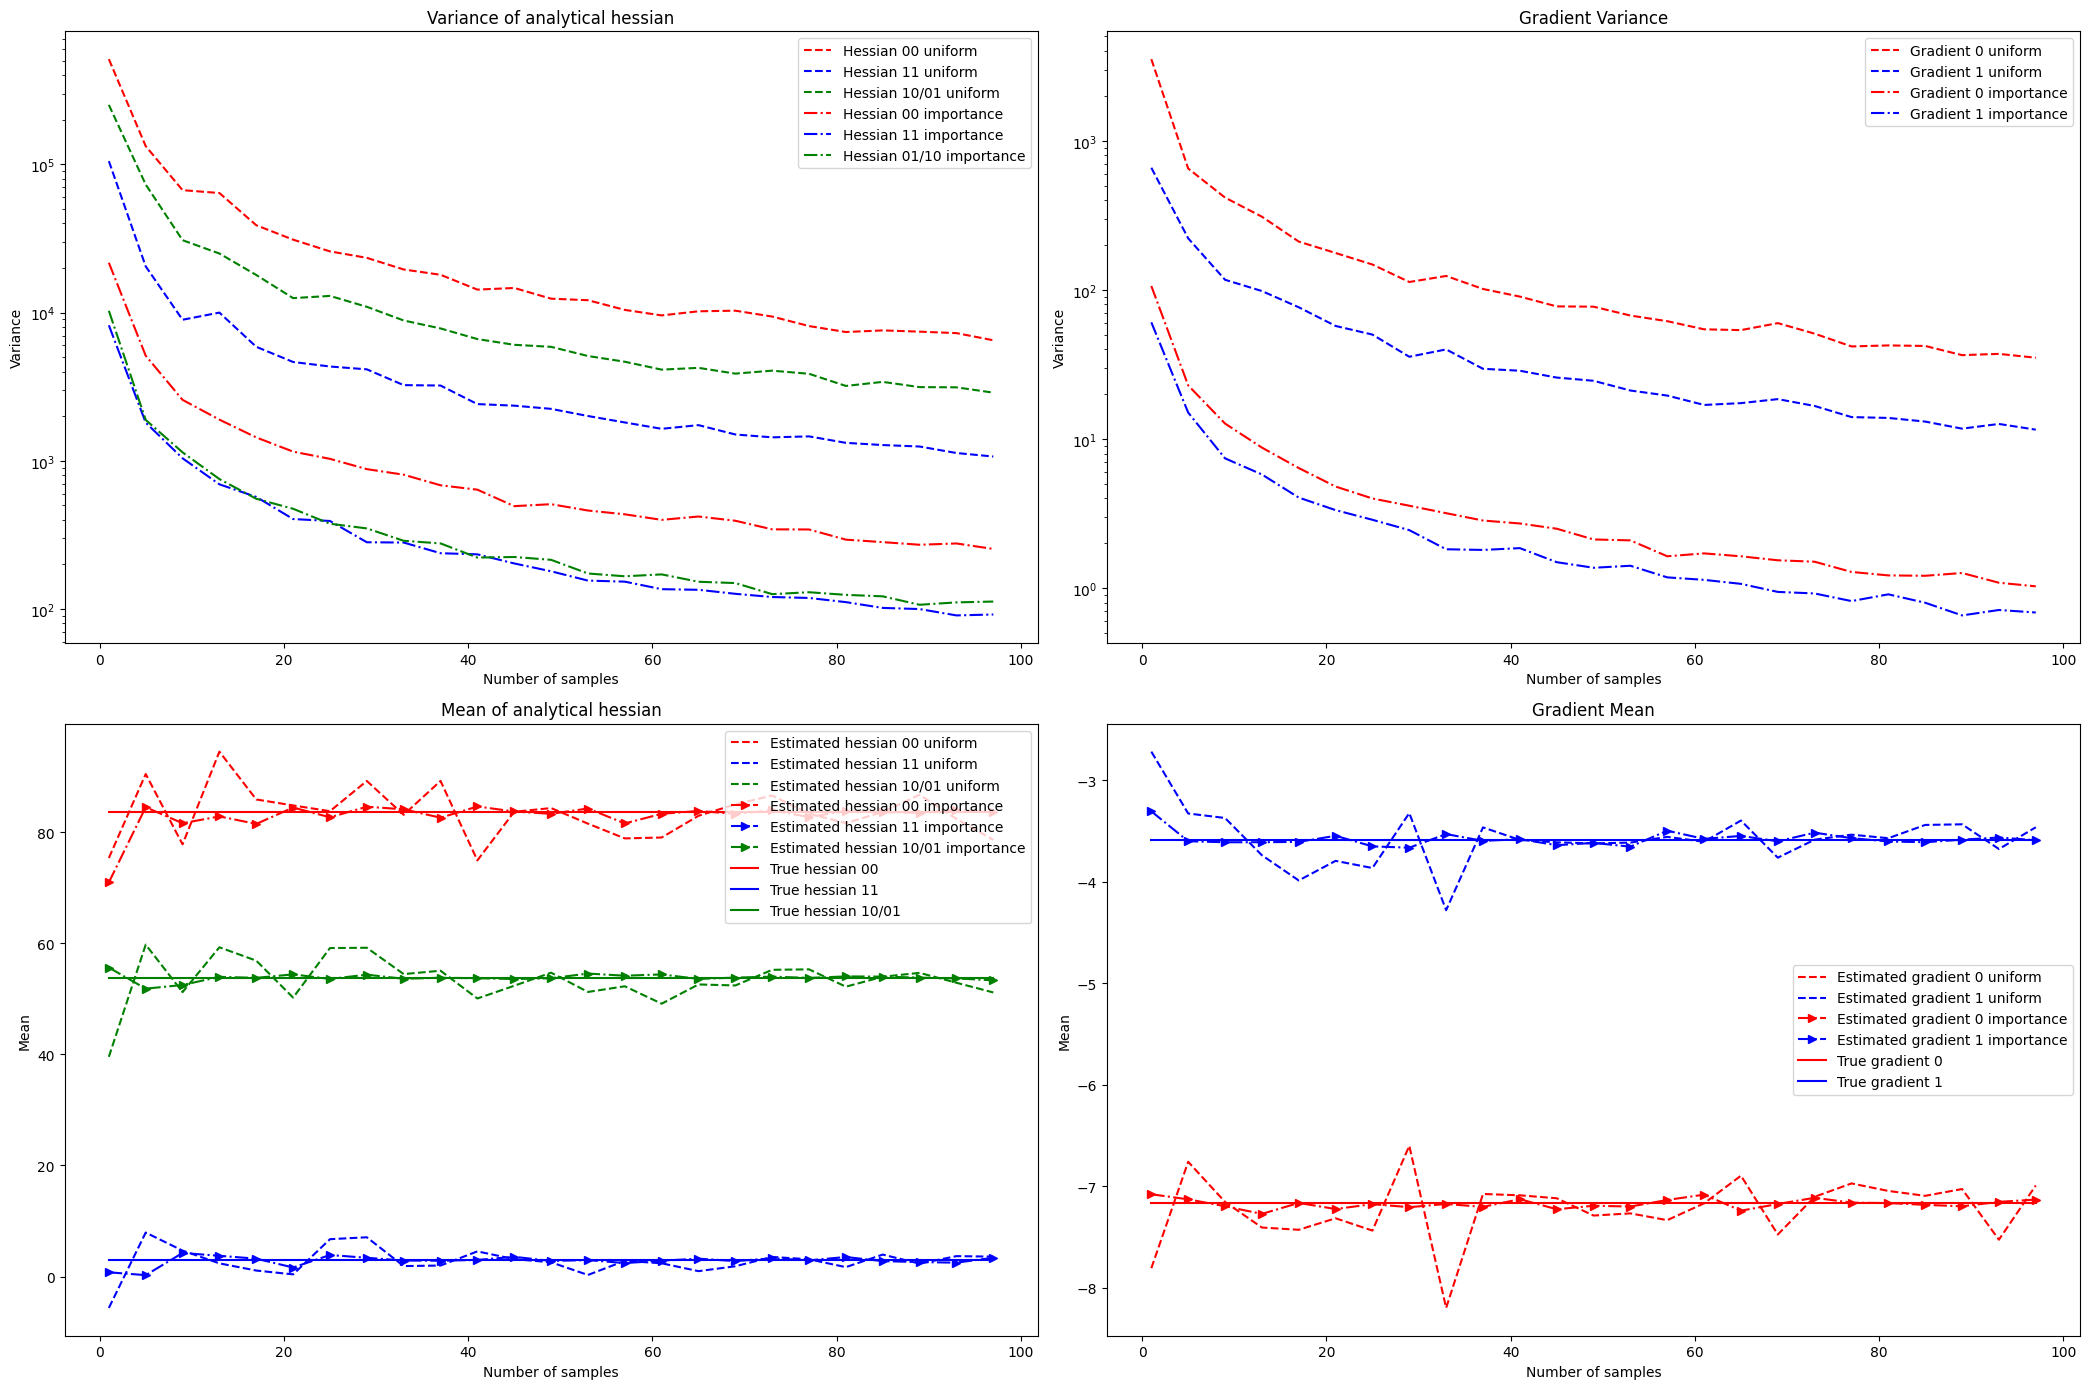

In [377]:
plt.figure(figsize=(21,14))
plt.subplot(2,2,1)
plt.plot(number_of_samples, hess_conv_var_uniform[:,0,0], color='red', linestyle='--', label="Hessian 00 uniform")
plt.plot(number_of_samples, hess_conv_var_uniform[:,1,1], color='blue', linestyle='--', label="Hessian 11 uniform")
plt.plot(number_of_samples, hess_conv_var_uniform[:,1,0], color='green', linestyle='--', label="Hessian 10/01 uniform")
plt.plot(number_of_samples, hess_conv_var_importance[:,0,0], color='red', linestyle='-.', label="Hessian 00 importance")
plt.plot(number_of_samples, hess_conv_var_importance[:,1,1], color='blue', linestyle='-.', label="Hessian 11 importance")
plt.plot(number_of_samples, hess_conv_var_importance[:,0,1], color='green', linestyle='-.', label="Hessian 01/10 importance")
plt.title("Variance of analytical hessian")
plt.xlabel("Number of samples")
plt.yscale('log')
# plt.ylim(bottom=10)
plt.ylabel("Variance")
plt.legend()

plt.subplot(2,2,2)
plt.plot(number_of_samples, grad_var_uniform[0,:], color='red', linestyle='--', label="Gradient 0 uniform")
plt.plot(number_of_samples, grad_var_uniform[1,:], color='blue', linestyle='--', label="Gradient 1 uniform")
plt.plot(number_of_samples, grad_var_importance[0,:], color='red', linestyle='-.', label="Gradient 0 importance")
plt.plot(number_of_samples, grad_var_importance[1,:], color='blue', linestyle='-.', label="Gradient 1 importance")
plt.xlabel("Number of samples")
plt.ylabel("Variance")
plt.yscale('log')
# plt.ylim(bottom=1)
plt.title("Gradient Variance")
plt.legend()

plt.subplot(2,2,3)
plt.plot(number_of_samples, hess_conv_mean_uniform[:,0,0], color='red', linestyle='--', label="Estimated hessian 00 uniform")
plt.plot(number_of_samples, hess_conv_mean_uniform[:,1,1], color='blue', linestyle='--', label="Estimated hessian 11 uniform")
plt.plot(number_of_samples, hess_conv_mean_uniform[:,1,0], color='green', linestyle='--', label="Estimated hessian 10/01 uniform")
plt.plot(number_of_samples, hess_conv_mean_importance[:,0,0], color='red', linestyle='-.', marker='>', label="Estimated hessian 00 importance")
plt.plot(number_of_samples, hess_conv_mean_importance[:,1,1], color='blue', linestyle='-.', marker='>', label="Estimated hessian 11 importance")
plt.plot(number_of_samples, hess_conv_mean_importance[:,1,0], color='green', linestyle='-.', marker='>', label="Estimated hessian 10/01 importance")
plt.plot(number_of_samples, true_hess[:,0,0], color='red', label="True hessian 00")
plt.plot(number_of_samples, true_hess[:,1,1], color='blue', label="True hessian 11")
plt.plot(number_of_samples, true_hess[:,1,0], color='green', label="True hessian 10/01")
plt.plot()
plt.xlabel("Number of samples")
plt.ylabel("Mean")
plt.title("Mean of analytical hessian")
plt.tight_layout()
plt.legend()

plt.subplot(2,2,4)
plt.plot(number_of_samples, grad_mean_uniform[0,:], color='red', linestyle='--', label="Estimated gradient 0 uniform")
plt.plot(number_of_samples, grad_mean_uniform[1,:], color='blue', linestyle='--', label="Estimated gradient 1 uniform")
plt.plot(number_of_samples, grad_mean_importance[0,:], color='red', linestyle='-.', marker='>', label="Estimated gradient 0 importance")
plt.plot(number_of_samples, grad_mean_importance[1,:], color='blue', linestyle='-.', marker='>', label="Estimated gradient 1 importance")
plt.plot(number_of_samples, diff[:,0], color='red', label="True gradient 0")
plt.plot(number_of_samples, diff[:,1], color='blue', label="True gradient 1")
plt.xlabel("Number of samples")
plt.ylabel("Mean")
plt.title("Gradient Mean")
plt.legend()
plt.tight_layout()
plt.show()


## HVP epsilon

In [342]:
min_sample = 1
add_sample = 100
step = 4
sigma1, sigma2 = 0.1, 0.1
number_of_samples = np.arange(min_sample, min_sample+add_sample, step) # for first plot against samples
epses = np.array([0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 3, 5])*sigma2 # for second plot against epsilon
samples_length = len(number_of_samples)

f_args = {'sigma': sigma1}
kernel_args = {'sigma': sigma2}

x = (torch.rand(2, device=device) - 0.5)*3*sigma2
# x = torch.tensor([0.3, 0.15], requires_grad=True, device=device)
n = 1000 # number of iterations for each point
eps = 0.3*sigma2
random_vec = torch.randn(2).to(device)

# compute true HV
new_sigma = (sigma1**2 + sigma2**2)**0.5
true_HV = torch.matmul(gauss_hessian(x.clone().detach().unsqueeze(0), new_sigma, device=device), random_vec).cpu().detach().numpy()
true_HV1 = np.tile(true_HV, (samples_length, 1))
true_HV2 = np.tile(true_HV, (len(epses), 1))

In [343]:
HV_var = np.zeros((samples_length, 2))
HV_mean = np.zeros((samples_length, 2))
for i in tqdm(range(samples_length)):
    HV_samples = np.zeros((n,2))
    start_time = time.time()
    for j in range(n):
        # importance samples
        sampler_args = {'sigma': sigma2, 'is_antithetic': True, 'dir':0}
        HV_func = smoothFn_hv_fd(gaussian_nd,n=number_of_samples[i], f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device, epsilon=eps)
        HV_samples[j, :] = HV_func(x.unsqueeze(0), random_vec).cpu().detach().numpy()
    # print("Number of samples: ", number_of_samples[i])
    # print("Time taken: ", time.time()-start_time)
    HV_mean[i, :] = np.mean(HV_samples, axis=0)
    HV_var[i, :] = variance(HV_samples, true_HV, axis=0)
    


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [02:13<00:00,  5.32s/it]


In [344]:
n_samples = 100
HV_var_eps = np.zeros((len(epses), 2))
HV_mean_eps = np.zeros((len(epses), 2))
for i in tqdm(range(len(epses))):
    HV_samples = np.zeros((n,2))
    start_time = time.time()
    for j in range(n):
        # importance samples
        sampler_args = {'sigma': sigma2, 'is_antithetic': True, 'dir':0}
        HV_func = smoothFn_hv_fd(gaussian_nd,n=n_samples, f_args=f_args, kernel_args=kernel_args, sampler_args=sampler_args, device=device, epsilon=epses[i])
        HV_samples[j, :] = HV_func(x.unsqueeze(0), random_vec).cpu().detach().numpy()
    # print("Number of samples: ", number_of_samples[i])
    # print("Time taken: ", time.time()-start_time)
    HV_mean_eps[i, :] = np.mean(HV_samples, axis=0)
    HV_var_eps[i, :] = variance(HV_samples, true_HV, axis=0)
    

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:57<00:00,  5.74s/it]


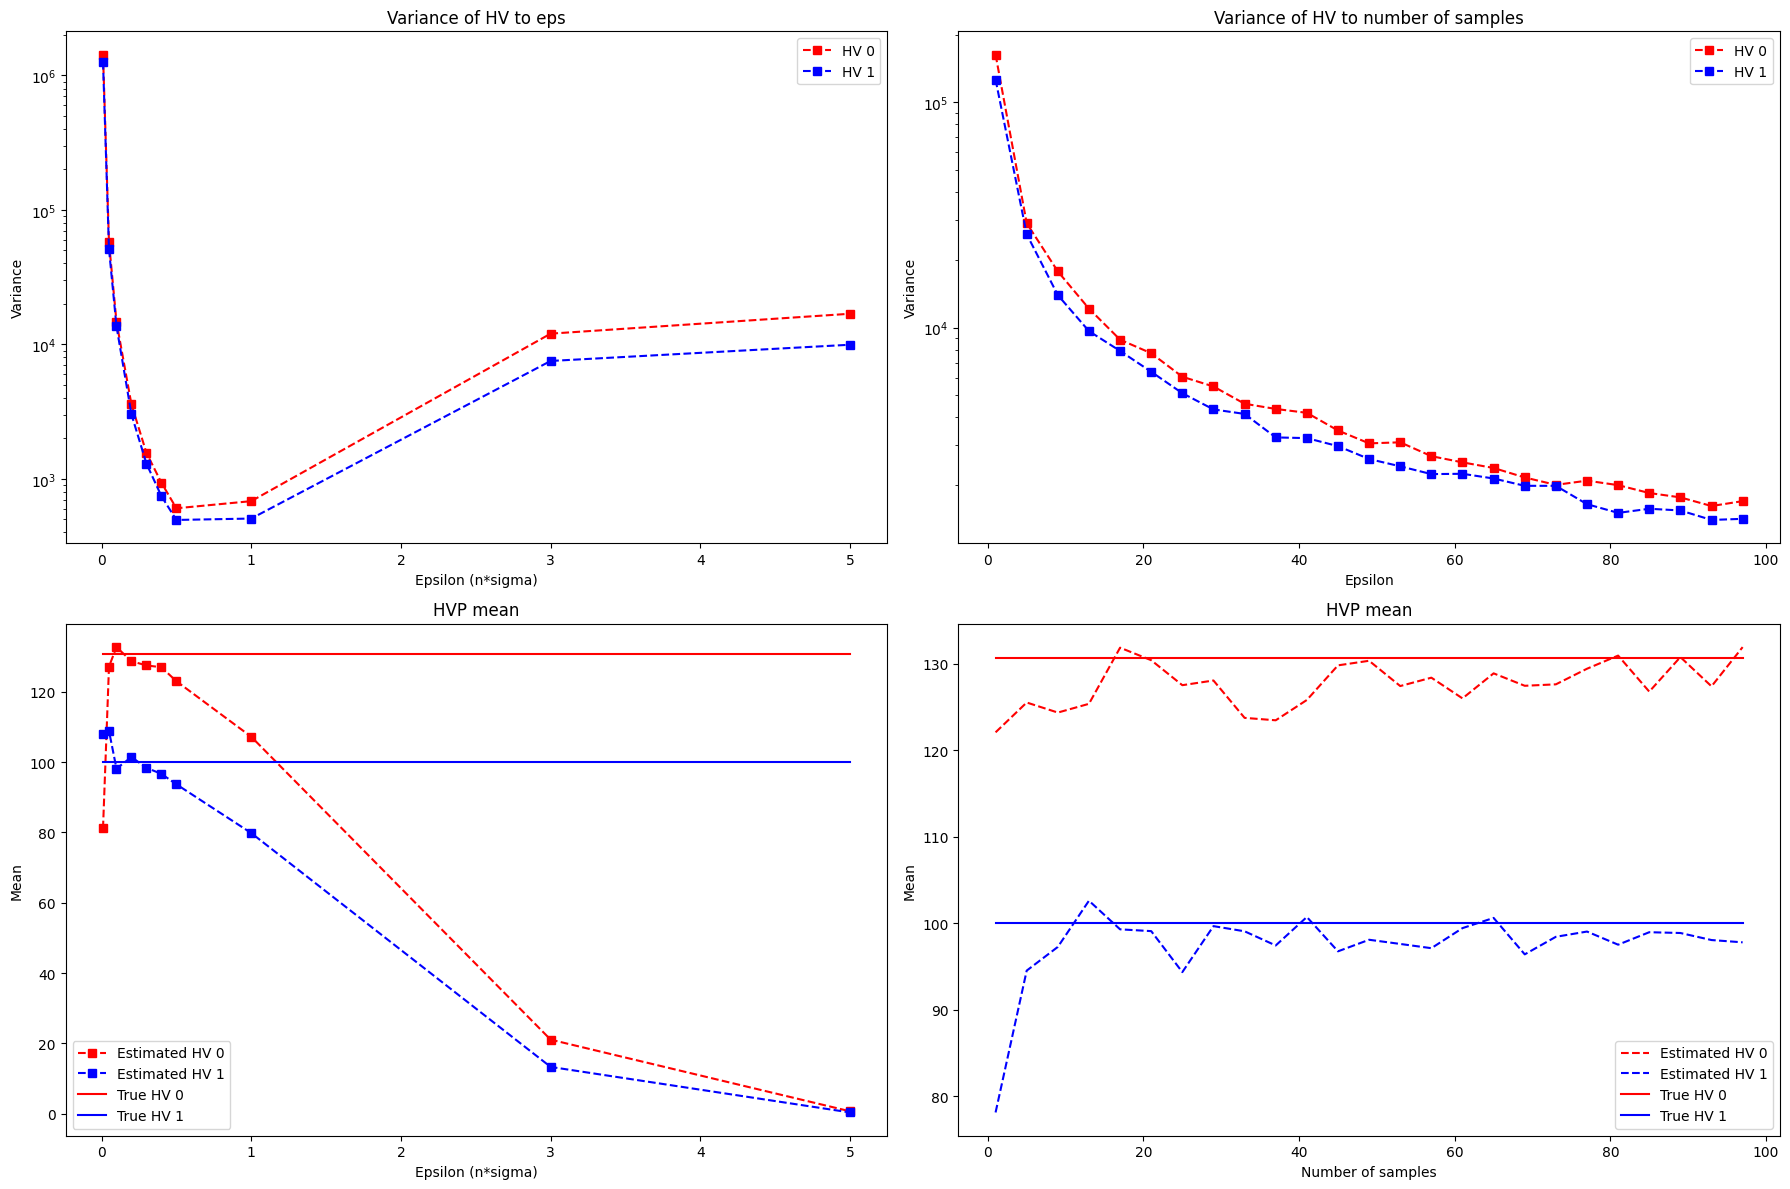

In [345]:
plt.figure(figsize=(18,12))
plt.subplot(2,2,2)
plt.plot(number_of_samples, HV_var[:,0], color='red', linestyle='--', label="HV 0", marker='s')
plt.plot(number_of_samples, HV_var[:,1], color='blue', linestyle='--', label="HV 1", marker='s')
plt.title("Variance of HV to number of samples")
plt.yscale('log')
plt.xlabel("Epsilon")
# plt.ylim(bottom=10)
plt.ylabel("Variance")
plt.legend()

plt.subplot(2,2,1)
plt.plot(epses/sigma2, HV_var_eps[:,0], color='red', linestyle='--', label="HV 0", marker='s')
plt.plot(epses/sigma2, HV_var_eps[:,1], color='blue', linestyle='--', label="HV 1", marker='s')
plt.xlabel("Epsilon (n*sigma)")
plt.ylabel("Variance")
plt.yscale('log')
# plt.xscale('log')
# plt.ylim(bottom=1)
plt.title("Variance of HV to eps")
plt.legend()

plt.subplot(2,2,4)
plt.plot(number_of_samples, HV_mean[:,0], color='red', linestyle='--', label="Estimated HV 0")
plt.plot(number_of_samples, HV_mean[:,1], color='blue', linestyle='--', label="Estimated HV 1")
plt.plot(number_of_samples, true_HV1[:,0], color='red', label="True HV 0")
plt.plot(number_of_samples, true_HV1[:,1], color='blue', label="True HV 1")
plt.plot()
plt.xlabel("Number of samples")
plt.ylabel("Mean")
plt.title("HVP mean")
plt.tight_layout()
plt.legend()

plt.subplot(2,2,3)
plt.plot(epses/sigma2, HV_mean_eps[:, 0], color='red', linestyle='--', label="Estimated HV 0", marker='s')
plt.plot(epses/sigma2, HV_mean_eps[:, 1], color='blue', linestyle='--', label="Estimated HV 1", marker='s')
plt.plot(epses/sigma2, true_HV2[:,0], color='red', label="True HV 0")
plt.plot(epses/sigma2, true_HV2[:,1], color='blue', label="True HV 1")
plt.xlabel("Epsilon (n*sigma)")
plt.ylabel("Mean")
# plt.xscale('log')
plt.title("HVP mean")
plt.legend()
plt.tight_layout()
plt.show()


# Example problem on parabola

Text(0.5, 1.0, 'Potential function')

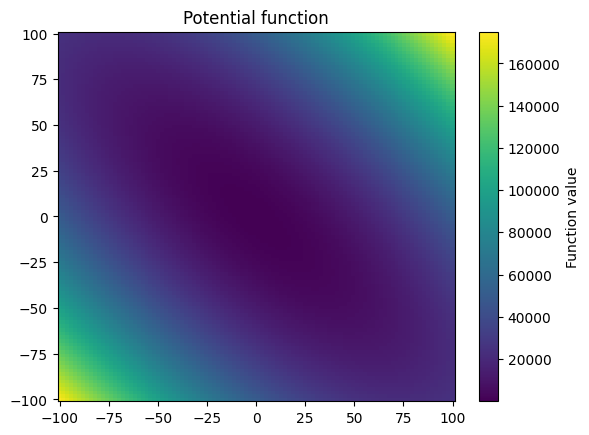

In [114]:
def potential(x, a=1.0, b=1.0, c=1.0):
    '''
    For 2d potential
    x is shape (n, 2)
    '''
    return 0.5*(a*x[:, 0]**2 + b*x[:, 1]**2 + c*x[:, 0]*x[:, 1])

a, b, c = 10, 10, 15

def logging_potential(theta, y_hist, x_hist, i, interval=5):
    y = potential(theta, a, b, c)
    y_hist.append(y)
    x_hist.append(theta)

    if (i+1) % interval == 0:
        print("Iteration: {}, y:{}, x:{}".format(i, y, theta))
    return y_hist, x_hist

grid_size = 100
x1 = np.linspace(-100, 100, grid_size)
x2 = np.linspace(-100, 100, grid_size)
X1, X2 = np.meshgrid(x1, x2)
x = np.stack([X1, X2], axis=2).reshape(-1, 2)
y = potential(torch.tensor(x, dtype=torch.float32), a, b, c).reshape((grid_size,grid_size))

pcm = plt.pcolor(X1, X2, y)
cbar = plt.colorbar(pcm)
cbar.set_label('Function value')
plt.title('Potential function')

In [128]:
n_samples = 4
sigma = 0.1

# plt.rcParams['figure.figsize'] = (12, 6)
ctx_args = {'nsamples':n_samples}
cg_potential_hparams = {'sigma_annealing': False,
           'epochs': 10000,
           'tol': 1e-10, # tolerance for CG
           'NR_max_iter': 200, # max iter for NR line search in CG
           'NR_tol': 1e-3, # tolerance for NR line search in CG
           'recompute': 2, # recompute the exact residual every n iterations
           'TR':True, # use trust region
           'TR_rate':0.1, # trust region rate
           'plot_interval':100 # number of iterations to plot
           }


# --------------- run optimization CG
max_iter = cg_potential_hparams['epochs']
theta = torch.tensor([1000.0, -1000.0], device=device)
f_args = {'a': a, 'b': b, 'c': c}
kernel_args = {'sigma': sigma}
sampler_args = {'sigma': sigma, 'is_antithetic': True, 'dir':(0,0)}
start_time = time.time()
x, _, _ = NCG_smooth(potential, theta, max_iter, log_func=logging_potential, f_args=f_args, kernel_args=kernel_args, 
           sampler_args=sampler_args, opt_args=cg_potential_hparams, ctx_args=ctx_args, device=device)
print('Final result: ', x)
print("Time taken: ", time.time()-start_time)


Iteration: 99, y:tensor([4638.4219], device='cuda:0'), x:tensor([[-41.7752,  44.1444]], device='cuda:0')
Iteration: 199, y:tensor([94.0982], device='cuda:0'), x:tensor([[ 5.3631, -6.5195]], device='cuda:0')
Iteration: 299, y:tensor([1.2618e-07], device='cuda:0'), x:tensor([[ 0.0002, -0.0001]], device='cuda:0')
Iteration: 399, y:tensor([3.9935e-05], device='cuda:0'), x:tensor([[-0.0043,  0.0031]], device='cuda:0')
Converged at  429
Iteration: 428, y:tensor([9.8739e-15], device='cuda:0'), x:tensor([[-6.4123e-08,  6.1355e-08]], device='cuda:0')
Final result:  tensor([[-6.4123e-08,  6.1355e-08]], device='cuda:0')
Time taken:  7.550740003585815


In [25]:
ctx_args = {'nsamples':10}
newton_params = {'sigma_annealing': True,
           'epochs': 1000,
           'sigma': sigma,
           'anneal_const_first': 200,
           'anneal_const_last': 0,
           'anneal_sigma_min': 0.01,
           'learning_rate':0.1,
           'tol': 1e-6, # tolerance for newton
           'hessian mod':False,
           'plot_interval':100 # number of iterations to plot
           }


# --------------- run optimization newton
max_iter = newton_params['epochs']
theta = torch.tensor([1000.0, 1000.0], device=device)
f_args = {'a': a, 'b': b, 'c': c}
kernel_args = {'sigma': sigma}
sampler_args = {'sigma': sigma, 'is_antithetic': True, 'dir':(0,0)}
start_time = time.time()
x, _ = newton_smooth(potential, theta, max_iter, log_func=logging_potential, f_args=f_args, kernel_args=kernel_args, 
           sampler_args=sampler_args, opt_args=newton_params, ctx_args=ctx_args, device=device)
print('Final result: ', x)
print("Time taken: ", time.time()-start_time)

Iteration: 99, y:tensor([6369958.5000], device='cuda:0'), x:tensor([[938.1373, 892.6022]], device='cuda:0')
Iteration: 199, y:tensor([4724189.], device='cuda:0'), x:tensor([[846.3530, 697.6049]], device='cuda:0')
Iteration: 299, y:tensor([4679111.5000], device='cuda:0'), x:tensor([[863.2504, 652.9833]], device='cuda:0')
Iteration: 399, y:tensor([3756591.], device='cuda:0'), x:tensor([[738.0910, 653.4569]], device='cuda:0')
Iteration: 499, y:tensor([4111412.5000], device='cuda:0'), x:tensor([[751.6687, 720.6953]], device='cuda:0')
converged at:  503
Final result:  tensor([[7.5662e+02, 4.0065e+07]], device='cuda:0')
Time taken:  3.8558058738708496


In [274]:
# def adam_opt(func, x0, max_iter, log_func, f_args, kernel_args, sampler_args, opt_args, ctx_args, device='cuda'):
#     self_kernel_args = kernel_args.copy()
#     self_sampler_args = sampler_args.copy()
#     optim = torch.optim.Adam([x0], lr=opt_args['learning_rate'])
#     conv_thres = opt_args.get('conv_thres', 10)
#     diff_func = smoothFn_gradient(func=func, sampler='importance_gradgauss', n=ctx_args['nsamples'], f_args=f_args,
#                         kernel_args=self_kernel_args, sampler_args=self_sampler_args, device=device)
#     diff_func_check = smoothFn_gradient(func=func, sampler='importance_gradgauss', n=500, f_args=f_args,
#                         kernel_args=self_kernel_args, sampler_args=self_sampler_args, device=device)
#     img_errors, param_errors = [], []
#     convergence = 0
#     converged = False
#     sigma = self_sampler_args['sigma']
#     for i in range(max_iter):
#         optim.zero_grad()
#         self_kernel_args['sigma'] = sigma
#         self_sampler_args['sigma'] = sigma
#         diff_func = smoothFn_gradient(func=func, sampler='importance_gradgauss', n=n_samples, f_args=f_args,
#                                 kernel_args=self_kernel_args, sampler_args=self_sampler_args, device=device) 
#         x0.grad = diff_func(x0.unsqueeze(0)).squeeze(0)
#         optim.step()
#         img_errors, param_errors = log_func(x0.unsqueeze(0), img_errors, param_errors, i, interval=opt_args['plot_interval'])
#         if torch.norm(diff_func(x0.unsqueeze(0))) < opt_args['tol']:
#             if converged:
#                 convergence += 1
#             else:
#                 convergence = 1
#             converged = True
#             # print(convergence)
#             if convergence >= conv_thres:
#                 if torch.norm(diff_func_check(x0.unsqueeze(0))) < opt_args['tol']:
#                     break
#                 else:
#                     convergence = 0
#         else:
#             converged = False
#         if opt_args.get('sigma_annealing', False):
#             sigma = sigma_scheduler(i, opt_args, sigma)
#     return x0, img_errors, param_errors


In [ ]:

n_samples = 4
sigma = 0.1

ctx_args = {'nsamples':n_samples}
adam_params = {'epochs': 20000,
           'learning_rate':0.5,
           'plot_interval':1000, # number of iterations to plot
           'tol':1e-10
           }

f_args = {'a': a, 'b': b, 'c': c}
kernel_args = {'sigma': sigma}
sampler_args = {'sigma': sigma, 'is_antithetic': True, 'dir':(0,0)}

# --------------- run optimization Adam
theta = torch.tensor([1000.0, -1000.0], device=device)
start_time = time.time()
x, _, _ = adam_opt(potential, theta, adam_params['epochs'], log_func=logging_potential, f_args=f_args, kernel_args=kernel_args, 
           sampler_args=sampler_args, opt_args=adam_params, ctx_args=ctx_args, device=device)
print('time taken: ', time.time()-start_time)
print('final result: ', x)

In [129]:
# comparison
ctx_args = {'nsamples':2}
n_starting_points = 50
starting_points = torch.rand(n_starting_points, 2, device=device)*200 + 800
lr_list = [0.5, 0.1, 0.05, 0.01, 1e-3]
time_hist = np.zeros((n_starting_points, 2+len(lr_list)))
loss_hist = np.zeros((n_starting_points, 2+len(lr_list)))
for i, theta in enumerate(starting_points):
    print(i)
    # --------------- run optimization CG
    time1 = time.time()
    x_cg, _ ,_ = NCG_smooth(potential, theta, cg_potential_hparams['epochs'], log_func=logging_potential, f_args=f_args, kernel_args=kernel_args, 
            sampler_args=sampler_args, opt_args=cg_potential_hparams, ctx_args=ctx_args, device=device)
    time2 = time.time()
    time_hist[i, 0] = time2 - time1
    loss_hist[i, 0] = potential(x_cg, a, b, c)
#     # --------------- run optimization newton
#     start_time = time.time()
#     x, _ = newton_smooth(potential, theta, max_iter, log_func=logging_potential, f_args=f_args, kernel_args=kernel_args, 
#             sampler_args=sampler_args, opt_args=newton_params, ctx_args=ctx_args, device=device)
#   time3 = time.time()
    # --------------- run optimization Adam
    for j, lr in enumerate(lr_list):
        clear_output(wait=True)
        adam_params['learning_rate'] = lr
        time3 = time.time()
        x_adam, _, _ = adam_opt(potential, theta, adam_params['epochs'], log_func=logging_potential, f_args=f_args, kernel_args=kernel_args,
                        sampler_args=sampler_args, opt_args=adam_params, ctx_args=ctx_args, device=device)
        time4 = time.time()
        loss_hist[i, 2+j] = potential(x_adam.unsqueeze(0), a, b, c)
        time_hist[i, 2+j] = time4 - time2
    

Iteration: 999, y:tensor([0.0070], device='cuda:0'), x:tensor([[-0.0306, -0.0086]], device='cuda:0')


In [131]:
np.save('potential_loss_hist.npy', loss_hist)
np.save('potential_time_hist.npy', time_hist)

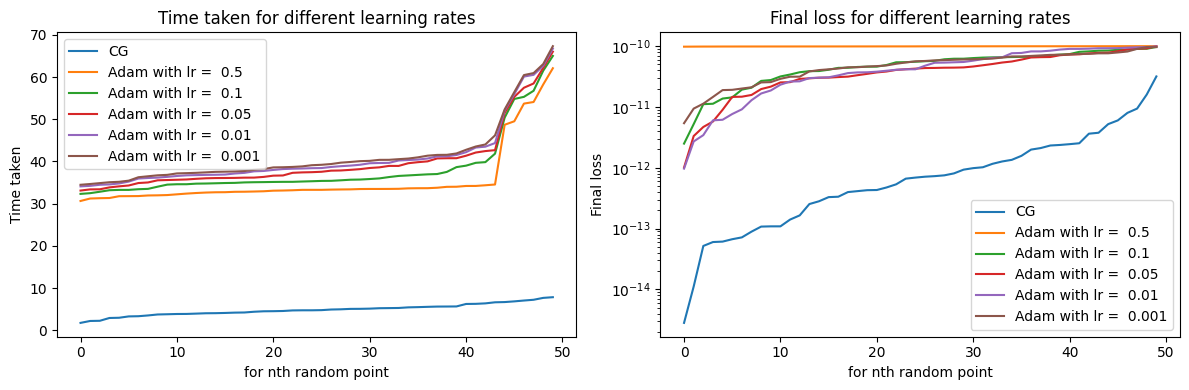

In [132]:
# Draw time plot and loss plot
loss_hist = np.sort(loss_hist, axis=0)
time_hist = np.sort(time_hist, axis=0)
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(time_hist[:, 0], label='CG')
for i, lr in enumerate(lr_list):
    plt.plot(time_hist[:, 2+i], label='Adam with lr =  {}'.format(lr))
plt.xlabel('for nth random point')
plt.ylabel('Time taken')
plt.title('Time taken for different learning rates')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss_hist[:, 0], label='CG')
for i, lr in enumerate(lr_list):
    plt.plot(loss_hist[:, 2+i], label='Adam with lr =  {}'.format(lr))
plt.xlabel('for nth random point')
plt.ylabel('Final loss')
plt.yscale('log')
plt.title('Final loss for different learning rates')
plt.legend()
plt.tight_layout()


# Example problem on box 2D

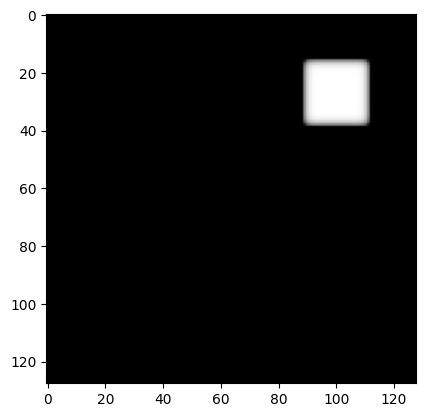

In [5]:
# From Michael's code box example
def get_rendering(theta, update_fn=None, ctx_args=None): 
  return draw_rect(theta[0], theta[1])


def draw_rect_old(px, py):   
  s, w, h, exp = 128, 0.2, 0.2, 10
  px = max(0+h, min(1-h, px))
  py = max(0+w, min(1-w, py))
  ss = torch.linspace(0, 1, s, device=device)
  x, y = torch.meshgrid(ss, ss)
  image = 1 - 2*(abs(((py - x)/w))**exp + abs((y - px)/h)**exp)
  return torch.flipud(image.clamp(0, 1)).unsqueeze(-1)

def draw_rect(px, py):   
  s, exp = 128, 10
  w, h = 0.1*s, 0.1*s
  px = max(0+h, min(s-h, px))
  py = max(0+w, min(s-w, py))
  ss = torch.arange(s, device=device)
  x, y = torch.meshgrid(ss, ss)
  image = 1 - 2*(abs(((py - x)/w))**exp + abs((y - px)/h)**exp)
  return torch.flipud(image.clamp(0, 1)).unsqueeze(-1)

plt.imshow(draw_rect(100, 100).cpu().numpy().squeeze(), cmap='gray')

def render_smooth(perturbed_theta, gt_img):
  '''
  Michael's code but without the average image
  '''
  with torch.no_grad():
      imgs, losses = [], []
      for j in range(perturbed_theta.shape[0]):       # for each sample
          perturbed_img = get_rendering(perturbed_theta[j, :])
          perturbed_loss = torch.nn.MSELoss()(perturbed_img, gt_img)
          imgs.append(perturbed_img)
          losses.append(perturbed_loss)
      loss = torch.stack(losses)
  return loss

def logging_box(theta, img_errors, param_errors, i, interval=5, **f_args):
    # plotting, logging, printing...
    theta = theta.squeeze()
    img_curr = get_rendering(theta)
    img_loss = torch.nn.MSELoss()(img_curr, ref_img).item()
    param_loss = torch.nn.MSELoss()(theta, gt_theta).item()
    img_errors.append(img_loss)
    param_errors.append(param_loss)

    print(f"Iter {i+1} - Img.Loss: {img_loss:.4f} - Param.Loss: {param_loss:.4f}")
    if (i+1) % interval == 0: 
        clear_output(wait=True)
        show_with_error(img_curr, ref_img, iter=i+1)
        plt_errors(img_errors, param_errors, title=f'Iter {i+1}')
    return img_errors, param_errors

n_samples = 10
sigma = 0.1

torch.manual_seed(0)

# set up initial and gt translation:
theta = torch.tensor([0.5, 0.6], requires_grad=True, device=device)*128
gt_theta = torch.tensor([0.3, 0.33], device=device)*128

init_img = get_rendering(theta)
ref_img = get_rendering(gt_theta)


## IS MSE

In [29]:
min_sample = 1
add_sample = 10
sigma = 0.1
x = torch.tensor([0.5, 0.4], requires_grad=True, device=device)
number_of_samples = np.arange(min_sample, min_sample+add_sample, 1)
n = 100
hess_conv_var = np.zeros((add_sample, 2, 2))
hess_conv_mean = np.zeros((add_sample, 2, 2))
grad_conv_var = np.zeros((add_sample, 2))
grad_conv_mean = np.zeros((add_sample, 2))
for i in range(add_sample):
    print("Number of samples: ", number_of_samples[i])
    ctx_args = {'antithetic': True, 'nsamples': number_of_samples[i], 'sigma': sigma,
                'sampler': sampler, 'device': device, 'gt_image': ref_img, 'update_fn': None}
    hess_conv = np.zeros((n,2,2))
    grad_conv = np.zeros((n,2))
    start_time = time.time()
    for j in range(n):
        f_args = {'gt_img': ref_img}
        kernel_args = {'sigma': sigma}
        sampler = 'importance_hessgauss'
        sampler_args = {'sigma': sigma, 'is_antithetic': True, 'dir':(0,0)}
        hess_func = smoothFn_hessian(func=render_smooth, sampler=sampler, n=number_of_samples[i], f_args=f_args,
                                            kernel_args=kernel_args, sampler_args=sampler_args, device=device)
        hess_conv[j,:,:] = hess_func(x.unsqueeze(0)).cpu().detach().numpy()  

        sampler = 'importance_gradgauss'
        grad_func = smoothFn_gradient(func=render_smooth, sampler=sampler, n=number_of_samples[i], f_args=f_args,
                                            kernel_args=kernel_args, sampler_args=sampler_args, device=device) 
        grad_conv[j,:] = grad_func(x.unsqueeze(0)).cpu().detach().numpy()  
    print("Time taken: ", time.time()-start_time)
    hess_conv_var[i, :, :] = np.var(hess_conv, axis=0)
    hess_conv_mean[i, :, :] = np.mean(hess_conv, axis=0)
    grad_conv_var[i,:] = np.var(grad_conv, axis=0)
    grad_conv_mean[i,:] = np.mean(grad_conv, axis=0)


Number of samples:  1
Time taken:  1.0643837451934814
Number of samples:  2
Time taken:  1.2367596626281738
Number of samples:  3
Time taken:  1.459930181503296
Number of samples:  4
Time taken:  1.6915771961212158
Number of samples:  5
Time taken:  1.9336895942687988
Number of samples:  6
Time taken:  2.163804054260254
Number of samples:  7
Time taken:  2.392087697982788
Number of samples:  8
Time taken:  2.6130404472351074
Number of samples:  9
Time taken:  2.855545997619629
Number of samples:  10
Time taken:  3.082075357437134


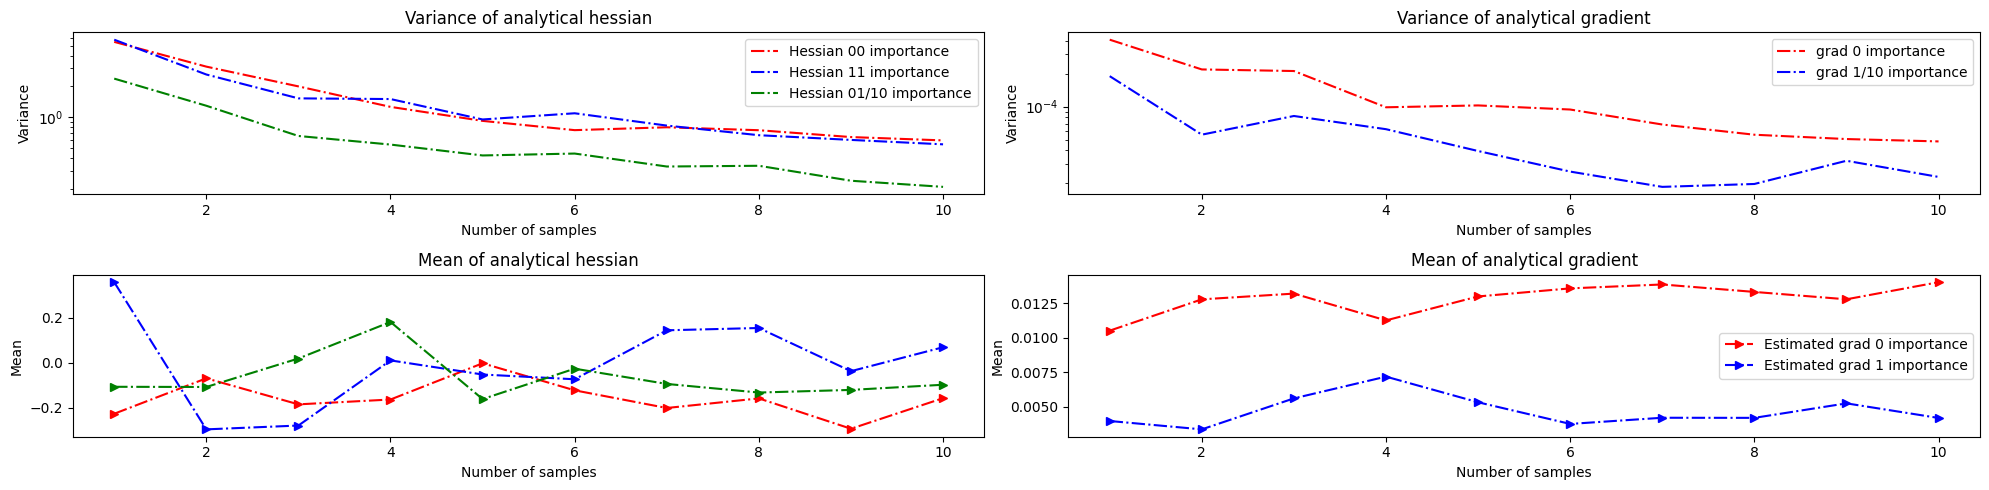

In [30]:
plt.figure(figsize=(20,5))
plt.subplot(2,2,1)
plt.plot(number_of_samples, hess_conv_var[:,0,0], color='red', linestyle='-.', label="Hessian 00 importance")
plt.plot(number_of_samples, hess_conv_var[:,1,1], color='blue', linestyle='-.', label="Hessian 11 importance")
plt.plot(number_of_samples, hess_conv_var[:,0,1], color='green', linestyle='-.', label="Hessian 01/10 importance")
plt.title("Variance of analytical hessian")
plt.xlabel("Number of samples")
plt.yscale('log')
plt.ylabel("Variance")
plt.legend()

plt.subplot(2,2,2)
plt.plot(number_of_samples, grad_conv_var[:,0], color='red', linestyle='-.', label="grad 0 importance")
plt.plot(number_of_samples, grad_conv_var[:,1], color='blue', linestyle='-.', label="grad 1/10 importance")
plt.title("Variance of analytical gradient")
plt.xlabel("Number of samples")
plt.yscale('log')
plt.ylabel("Variance")
plt.legend()

plt.subplot(2,2,3)
plt.plot(number_of_samples, hess_conv_mean[:,0,0], color='red', linestyle='-.', marker='>', label="Estimated hessian 00 importance")
plt.plot(number_of_samples, hess_conv_mean[:,1,1], color='blue', linestyle='-.', marker='>', label="Estimated hessian 11 importance")
plt.plot(number_of_samples, hess_conv_mean[:,1,0], color='green', linestyle='-.', marker='>', label="Estimated hessian 10/01 importance")
plt.plot()
plt.xlabel("Number of samples")
plt.ylabel("Mean")
plt.title("Mean of analytical hessian")

plt.subplot(2,2,4)
plt.plot(number_of_samples, grad_conv_mean[:,0], color='red', linestyle='-.', marker='>', label="Estimated grad 0 importance")
plt.plot(number_of_samples, grad_conv_mean[:,1], color='blue', linestyle='-.', marker='>', label="Estimated grad 1 importance")
plt.plot()
plt.xlabel("Number of samples")
plt.ylabel("Mean")
plt.title("Mean of analytical gradient")
plt.tight_layout()
plt.legend()


## Individual tests

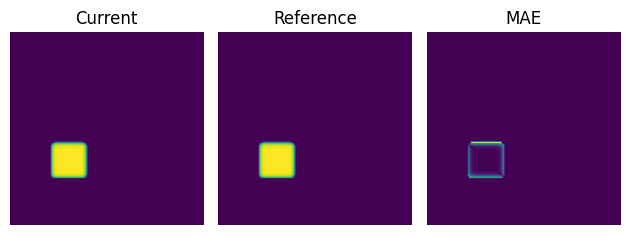

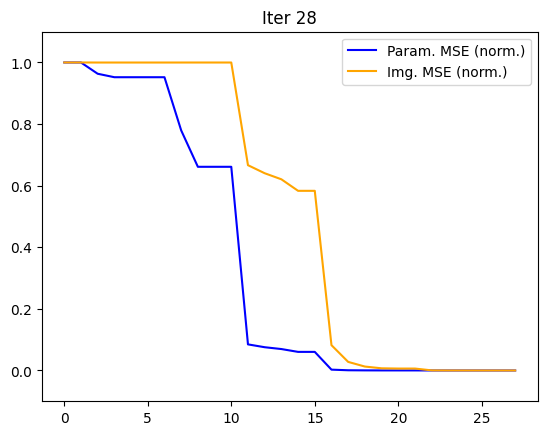

[[64.       84.48    ]
 [64.       84.48    ]
 [63.527714 83.69972 ]
 [63.317223 83.494606]
 [63.317223 83.494606]
 [63.317223 83.494606]
 [63.317223 83.494606]
 [59.786522 80.24731 ]
 [57.152843 77.759445]
 [57.152843 77.759445]
 [57.152843 77.759445]
 [35.37415  56.295395]
 [34.27522  55.17089 ]
 [33.50013  54.312305]
 [27.328121 47.209644]
 [27.328121 47.209644]
 [37.37546  39.889324]
 [38.0586   40.97921 ]
 [38.32622  41.350224]
 [38.368492 41.556046]
 [38.372494 41.592003]
 [38.372494 41.592003]
 [38.410133 42.120834]
 [38.414883 42.1882  ]
 [38.4147   42.205494]
 [38.40449  42.250538]
 [38.404816 42.24977 ]
 [38.40481  42.24959 ]]


In [11]:
# CG
n_samples = 10
sigma = 20
ctx_args = {'nsamples':n_samples}
hparams = {'sigma_annealing': True,
           'sigma': sigma,
           'epochs': 500,
           'anneal_const_first': 200,
           'anneal_const_last': 0,
           'anneal_sigma_min': 0.1,
           'tol': 1e-3, # tolerance for CG
           'TR':True,
           'HVP':False,
           'TR_bound': 50,
           'TR_rate':0.5,
           'NR_max_iter': 500, # max iter for NR line search in CG
           'NR_tol': 1e-3, # tolerance for NR line search in CG
           'recompute': 20, # recompute the exact residual every n iterations
           'conv_thres': 2, # convergence threshold
           'plot_interval':100 # number of iterations to plot
           }


# --------------- run optimization CG
max_iter = hparams['epochs']
theta = torch.tensor([0.5, 0.66], requires_grad=True, device=device)*128
show_with_error(init_img, ref_img, iter=0)
f_args = {'gt_img': ref_img}
kernel_args = {'sigma': sigma}
sampler = 'importance_hessgauss'
sampler_args = {'sigma': sigma, 'is_antithetic': True, 'dir':(0,0)}
x, _, x_list = NCG_smooth(render_smooth, theta, max_iter, log_func=logging_box, f_args=f_args, kernel_args=kernel_args, 
           sampler_args=sampler_args, opt_args=hparams, ctx_args=ctx_args, device=device)
print(x_list)

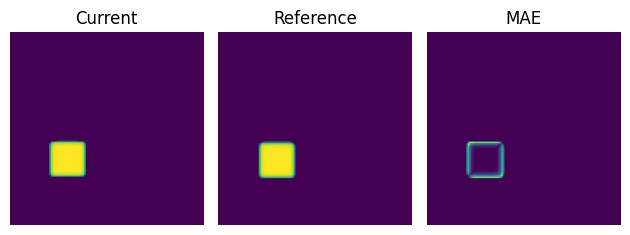

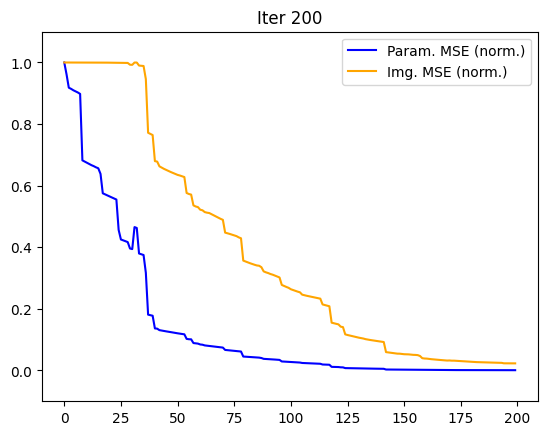

(tensor([[37.5535, 43.0659]], device='cuda:0', grad_fn=<SubBackward0>),
 array([[64.      , 71.68    ],
        [63.998024, 71.58001 ],
        [63.192116, 71.27824 ],
        [62.679146, 70.56864 ],
        [62.677402, 70.470146],
        [62.595078, 70.41696 ],
        [62.498802, 70.401505],
        [62.403038, 70.386   ],
        [62.33114 , 70.321625],
        [58.809868, 67.09443 ],
        [58.762047, 67.01176 ],
        [58.7308  , 66.922035],
        [58.660976, 66.858345],
        [58.612152, 66.77801 ],
        [58.521587, 66.754715],
        [58.45428 , 66.69052 ],
        [58.3639  , 66.67079 ],
        [58.323166, 66.13136 ],
        [57.33562 , 64.90324 ],
        [57.28642 , 64.826675],
        [57.253273, 64.742455],
        [57.216537, 64.660286],
        [57.139393, 64.61489 ],
        [57.08252 , 64.54642 ],
        [57.029236, 64.475746],
        [51.341274, 65.1376  ],
        [49.07984 , 65.277596],
        [49.01507 , 65.21949 ],
        [48.97706 , 65.14178 ],


In [5]:
# newton
sigma = 20
ctx_args = {'nsamples':n_samples}
hparams = {'sigma_annealing': True,
           'epochs': 200,
           'anneal_const_first': 200,
           'anneal_const_last': 0,
           'anneal_sigma_min': 0.5,
           'learning_rate':0.1,
           'tol': 1e-6, # tolerance for newton
           'hessian mod':True,
           'plot_interval':100 # number of iterations to plot
           }


# --------------- run optimization
max_iter = hparams['epochs']
theta = torch.tensor([0.5, 0.56], requires_grad=True, device=device)*128
show_with_error(init_img, ref_img, iter=0)
f_args = {'gt_img': ref_img}
kernel_args = {'sigma': sigma}
sampler = 'importance_hessgauss'
sampler_args = {'sigma': sigma, 'is_antithetic': True, 'dir':(0,0)}
newton_smooth(render_smooth, theta, max_iter, log_func=logging_box, f_args=f_args, kernel_args=kernel_args, 
           sampler_args=sampler_args, opt_args=hparams, ctx_args=ctx_args, device=device)


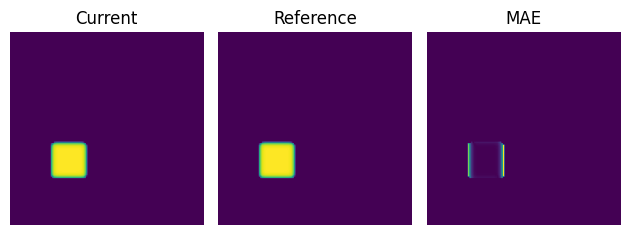

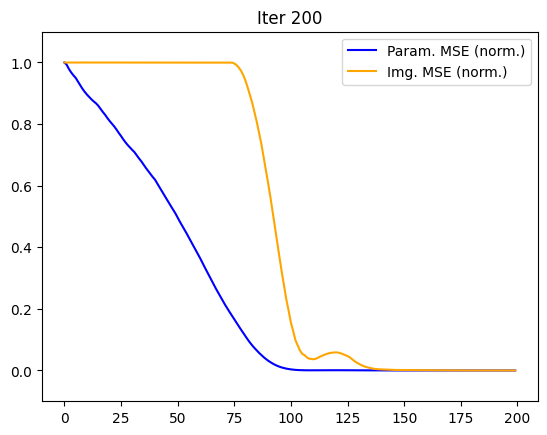

Iter 201 - Img.Loss: 0.0000 - Param.Loss: 0.0006
Iter 202 - Img.Loss: 0.0000 - Param.Loss: 0.0006
Iter 203 - Img.Loss: 0.0000 - Param.Loss: 0.0005
Iter 204 - Img.Loss: 0.0000 - Param.Loss: 0.0004
Iter 205 - Img.Loss: 0.0000 - Param.Loss: 0.0003
Iter 206 - Img.Loss: 0.0000 - Param.Loss: 0.0003
Iter 207 - Img.Loss: 0.0000 - Param.Loss: 0.0002
Iter 208 - Img.Loss: 0.0000 - Param.Loss: 0.0002
Iter 209 - Img.Loss: 0.0000 - Param.Loss: 0.0001
Iter 210 - Img.Loss: 0.0000 - Param.Loss: 0.0001
Iter 211 - Img.Loss: 0.0000 - Param.Loss: 0.0001
Iter 212 - Img.Loss: 0.0000 - Param.Loss: 0.0001
Iter 213 - Img.Loss: 0.0000 - Param.Loss: 0.0001
Iter 214 - Img.Loss: 0.0000 - Param.Loss: 0.0001
Iter 215 - Img.Loss: 0.0000 - Param.Loss: 0.0001
Iter 216 - Img.Loss: 0.0000 - Param.Loss: 0.0001


In [8]:
# adam
ctx_args = {'nsamples':n_samples}
adam_box_params = {'epochs': 1000,
           'learning_rate':5e-1,
           'plot_interval':100, # number of iterations to plot
           'tol':1e-6
           }

# --------------- run optimization Adam
max_iter = hparams['epochs']
theta = torch.tensor([0.7, 0.7], device=device)*128
show_with_error(init_img, ref_img, iter=0)
f_args = {'gt_img': ref_img}
kernel_args = {'sigma': sigma}
sampler = 'importance_hessgauss'
sampler_args = {'sigma': sigma, 'is_antithetic': True, 'dir':(0,0)}
x_adam, _, _ = adam_opt(render_smooth, theta, adam_box_params['epochs'], log_func=logging_box, f_args=f_args, kernel_args=kernel_args,
                sampler_args=sampler_args, opt_args=adam_box_params, ctx_args=ctx_args, device=device)

## batch test

In [118]:
# comparison
def log_none(*args, **kargs):
    return [],[]

gt_theta = torch.tensor([0.3, 0.3 ], device=device)*128
ref_img = get_rendering(gt_theta)

n_samples = 6
sigma = 35
ctx_args = {'nsamples':n_samples}
cg_box_hparams = {'sigma_annealing': True,
           'sigma': sigma,
           'epochs': 500,
           'anneal_const_first': 10,
           'anneal_const_last': 410,
           'anneal_sigma_min': 0.05,
           'tol': 5e-5, # tolerance for CG
           'TR':True,
           'TR_bound': 20,
           'TR_rate': 0.5,
           'NR_max_iter': 300, # max iter for NR line search in CG
           'NR_tol': 1e-3, # tolerance for NR line search in CG
           'recompute': 1, # recompute the exact residual every n iterations
           'conv_thres': 5, # convergence threshold
           'plot_interval':100 # number of iterations to plot
           }


newton_box_hparams = {'sigma_annealing': True,
           'sigma': sigma,
           'epochs': 1000,
           'anneal_const_first': 300,
           'anneal_const_last': 500,
           'anneal_sigma_min': 0.1,
           'TR':True,
           'TR_bound': 100,
           'TR_rate': 0.1,
           'learning_rate':0.2,
           'conv_thres': 7, # convergence threshold
           'tol': 5e-6, # tolerance for newton
           'hessian mod':True,
           'plot_interval':100 # number of iterations to plot
           }


adam_box_params = {'sigma_annealing': True,
           'sigma': sigma,
           'anneal_const_first': 500,
           'anneal_const_last': 0,
           'anneal_sigma_min': 0.01,
           'conv_thres': 10, # convergence threshold
           'epochs': 3000,
           'learning_rate':1e-1,
           'plot_interval':1000, # number of iterations to plot
           'tol':1e-7
           }

BFGS_box_params = {'sigma_annealing': True,
               'sigma': sigma,
                'anneal_const_first': 0,
                'anneal_const_last': 50,
                'anneal_sigma_min': 0.01,
                'TR':True,
                'TR_bound': 1e-3,
                'learning_rate':0.7,
                'line_search_fn': None, #'strong_wolfe',
                'history_size': 10,
                'conv_thres': 5, # convergence threshold
                'epochs': 100,
                'tol':1e-7,
                'plot_interval':100
                }

mi_hparams = {'nsamples': n_samples,
            'sigma': sigma,
            'learning_rate': 0.1,
            'sigma_annealing': True,
            'epochs': 3000,
            'anneal_const_first': 500,
            'anneal_const_last': 1000,
            'anneal_sigma_min': 0.01,
            'conv_thres': 10, # convergence threshold
            'tol':1e-8,
            'plot_interval':1000
           }

# set up mi_ctx_args: 
mi_ctx_args = {'antithetic': True, 'nsamples': mi_hparams['nsamples'], 'sigma': mi_hparams['sigma'],
            'sampler': 'importance', 'device': device, 'gt_image': ref_img, 'update_fn': None}
f_args = {'gt_img': ref_img}
kernel_args = {'sigma': sigma}
sampler_args = {'sigma': sigma, 'is_antithetic': True, 'dir':(0,0)}

# lr_list = [0.5, 0.1, 0.05, 0.01, 1e-3]
lr_list = [0.5, 0.1]


In [122]:
n_starting_points = 20
starting_points = (torch.rand(n_starting_points, 2, device=device)*0.3 + 0.42)*128
box_time_hist = np.zeros((n_starting_points, 4+len(lr_list))) # 1 for CG, 1 for Newton, 1 for michale, 1 for BFGS, lr for adam
box_loss_hist = np.zeros((n_starting_points, 4+len(lr_list)))

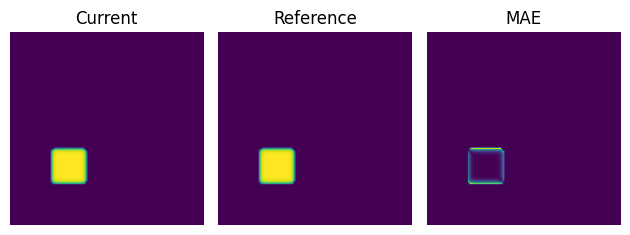

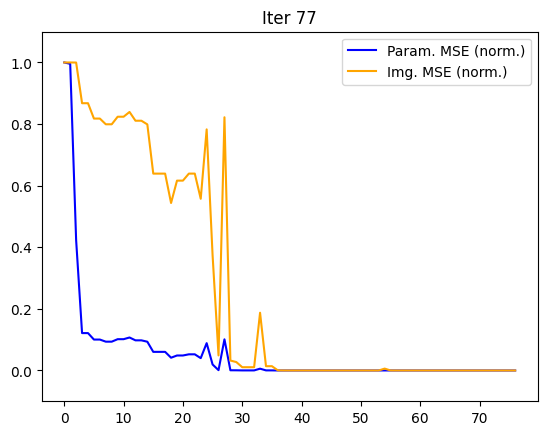

In [126]:
for i, theta in enumerate(starting_points):
    print(i)
    logging_box(theta.clone(), [], [], 0, 1)
    # --------------- run optimization CG
    time1 = time.time()
    x_cg, _ ,_ = NCG_smooth(render_smooth, theta.clone(), cg_box_hparams['epochs'], log_func=logging_box, f_args=f_args, kernel_args=kernel_args, 
            sampler_args=sampler_args, opt_args=cg_box_hparams, ctx_args=ctx_args, device=device)
    time2 = time.time()
    box_time_hist[i, 0] = time2 - time1
    param_loss = torch.nn.MSELoss()(x_cg, gt_theta).item()
    box_loss_hist[i, 0] = param_loss#render_smooth(x_cg, f_args['gt_img'])
    


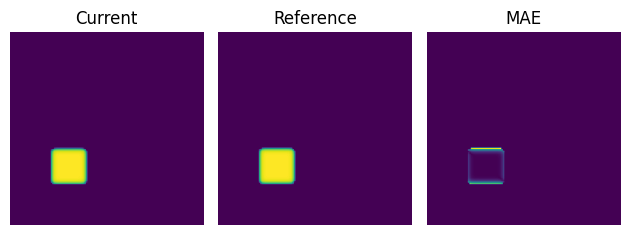

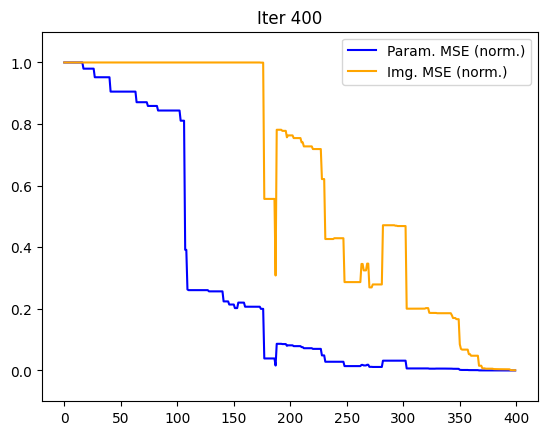

Iter 401 - Img.Loss: 0.0000 - Param.Loss: 0.0153
Iter 402 - Img.Loss: 0.0000 - Param.Loss: 0.0153
Iter 403 - Img.Loss: 0.0000 - Param.Loss: 0.0140
Iter 404 - Img.Loss: 0.0000 - Param.Loss: 0.0140
Iter 405 - Img.Loss: 0.0000 - Param.Loss: 0.0140
Iter 406 - Img.Loss: 0.0000 - Param.Loss: 0.0063
Iter 407 - Img.Loss: 0.0000 - Param.Loss: 0.0063
Iter 408 - Img.Loss: 0.0000 - Param.Loss: 0.0063
Iter 409 - Img.Loss: 0.0000 - Param.Loss: 0.0061
Iter 410 - Img.Loss: 0.0000 - Param.Loss: 0.0049
Iter 411 - Img.Loss: 0.0000 - Param.Loss: 0.0049
Iter 412 - Img.Loss: 0.0000 - Param.Loss: 0.0049
Iter 413 - Img.Loss: 0.0000 - Param.Loss: 0.0049
Iter 414 - Img.Loss: 0.0000 - Param.Loss: 0.0045
Iter 415 - Img.Loss: 0.0000 - Param.Loss: 0.0030
Iter 416 - Img.Loss: 0.0000 - Param.Loss: 0.0030
Iter 417 - Img.Loss: 0.0000 - Param.Loss: 0.0030
Iter 418 - Img.Loss: 0.0000 - Param.Loss: 0.0030
Iter 419 - Img.Loss: 0.0000 - Param.Loss: 0.0030
Iter 420 - Img.Loss: 0.0000 - Param.Loss: 0.0020
Iter 421 - Img.Loss:

In [127]:
for i, theta in enumerate(starting_points):
    print(i)
    logging_box(theta.clone(), [], [], 0, 1)
    time2 = time.time()
    # --------------- run optimization newton
    x_newton, _ = newton_smooth(render_smooth, theta.clone(), newton_box_hparams['epochs'], log_func=logging_box, f_args=f_args, kernel_args=kernel_args, 
            sampler_args=sampler_args, opt_args=newton_box_hparams, ctx_args=ctx_args, device=device)
    time3 = time.time()
    box_time_hist[i, 1] = time3 - time2
    param_loss = torch.nn.MSELoss()(x_newton, gt_theta).item()
    box_loss_hist[i, 1] = param_loss#render_smooth(x_newton, f_args['gt_img'])
    


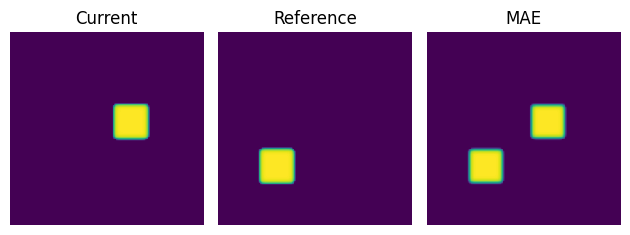

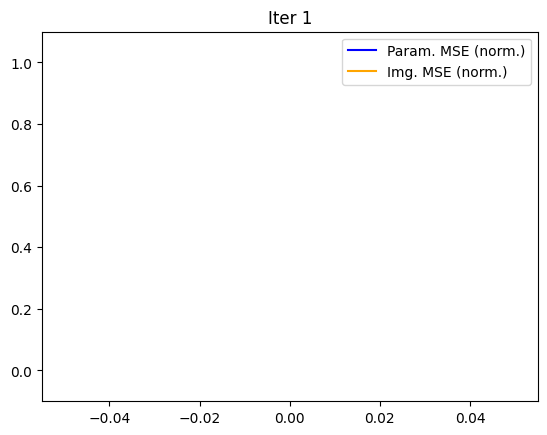

Iter 1 - Img.Loss: 0.0520 - Param.Loss: 1270.4539
Iter 2 - Img.Loss: 0.0520 - Param.Loss: 1270.4539
Iter 3 - Img.Loss: 0.0520 - Param.Loss: 1270.1604
Iter 4 - Img.Loss: 0.0520 - Param.Loss: 1270.0264
Iter 5 - Img.Loss: 0.0520 - Param.Loss: 1270.0264
Iter 6 - Img.Loss: 0.0520 - Param.Loss: 1265.4335
Iter 7 - Img.Loss: 0.0520 - Param.Loss: 1263.1130
Iter 8 - Img.Loss: 0.0520 - Param.Loss: 1153.9138
Iter 9 - Img.Loss: 0.0411 - Param.Loss: 149.4900
Iter 10 - Img.Loss: 0.0403 - Param.Loss: 144.7228
Iter 11 - Img.Loss: 0.0151 - Param.Loss: 18.7855
Iter 12 - Img.Loss: 0.0098 - Param.Loss: 10.6982
Iter 13 - Img.Loss: 0.0027 - Param.Loss: 1.9503
Iter 14 - Img.Loss: 0.0012 - Param.Loss: 0.7433
Iter 15 - Img.Loss: 0.0012 - Param.Loss: 0.7514
Iter 16 - Img.Loss: 0.0012 - Param.Loss: 0.7514
Iter 17 - Img.Loss: 0.0012 - Param.Loss: 0.7355
Iter 18 - Img.Loss: 0.0012 - Param.Loss: 0.7355
Iter 19 - Img.Loss: 0.0012 - Param.Loss: 0.7351
Iter 20 - Img.Loss: 0.0012 - Param.Loss: 0.7338
Iter 21 - Img.Loss:

KeyboardInterrupt: 

In [123]:
for i, theta in enumerate(starting_points):
    print(i)
    logging_box(theta.clone(), [], [], 0, 1)
    time3 = time.time()
    x_BFGS, _, _ = BFGS_opt(render_smooth, theta.clone(), BFGS_box_params['epochs'], log_func=logging_box, f_args=f_args, kernel_args=kernel_args,
                    sampler_args=sampler_args, opt_args=BFGS_box_params, ctx_args=ctx_args, device=device)
    time4 = time.time()
    box_loss_hist[i, 2] = torch.nn.MSELoss()(x_BFGS, gt_theta).item()
    box_time_hist[i, 2] = time4 - time3

In [4]:
# michaels

def render_smooth_mi(perturbed_theta, update_fn, ctx_args):
  with torch.no_grad():
      imgs, losses = [], []
      for j in range(perturbed_theta.shape[0]):       # for each sample
          perturbed_img = get_rendering(perturbed_theta[j, :])
          perturbed_loss = torch.nn.MSELoss()(perturbed_img, ctx_args['gt_image'])
          imgs.append(perturbed_img)
          losses.append(perturbed_loss)
      avg_img = torch.mean(torch.cat([x.unsqueeze(0) for x in imgs], dim=0), dim=0)
      loss = torch.stack(losses)
  return loss, avg_img

def mi_opt(x0, max_iter, log_func, opt_args, ctx_args, device='cuda'):
    self_ctx_args = ctx_args.copy()
    x0 = x0.clone().detach().requires_grad_(True)
    optim = torch.optim.Adam([x0], lr=opt_args['learning_rate'])
    get_smoothed_loss = smoothFn(render_smooth_mi,context_args=None,device=device)
    conv_thres = opt_args.get('conv_thres', 10)
    img_errors, param_errors = [], []
    convergence = 0
    converged = False
    sigma = self_ctx_args['sigma']
    for i in range(max_iter):
        optim.zero_grad()
        self_ctx_args['sigma'] = sigma
        loss, _ = get_smoothed_loss(x0.unsqueeze(0), self_ctx_args)
        optim.step()
        loss.backward()
        optim.step()
        img_errors, param_errors = log_func(x0.unsqueeze(0), img_errors, param_errors, i, interval=opt_args['plot_interval'])
        if torch.norm(x0.grad) < opt_args['tol']:
            if converged:
                convergence += 1
            else:
                convergence = 1
            converged = True
            # print(convergence)
            if convergence >= conv_thres:
                if torch.norm(x0.grad)< opt_args['tol']:
                    break
                else:
                    convergence = 0
        else:
            converged = False
        if opt_args.get('sigma_annealing', False):
            sigma = sigma_scheduler(i, opt_args, sigma)
    return x0, img_errors, param_errors


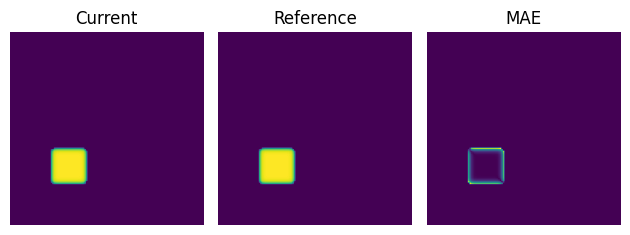

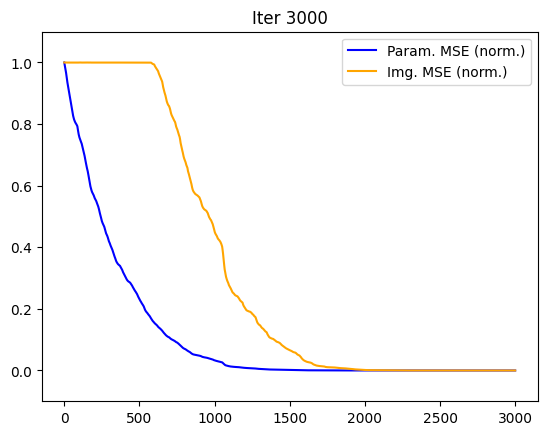

In [124]:
show_with_error(init_img, ref_img, iter=0)
for i, theta in enumerate(starting_points):
    print(i)
    logging_box(theta.clone(), [], [], 0, 1)
    # --------------- run optimization MI
    time1 = time.time()
    x_mi, _, _ = mi_opt(theta.clone(), mi_hparams['epochs'], log_func=logging_box, opt_args=mi_hparams, ctx_args=mi_ctx_args, device=device)
    time2 = time.time()
    box_time_hist[i, -1] = time2 - time1
    param_loss = torch.nn.MSELoss()(x_mi, gt_theta).item()
    box_loss_hist[i, -1] = param_loss#render_smooth(x_mi, f_args['gt_img'])
    

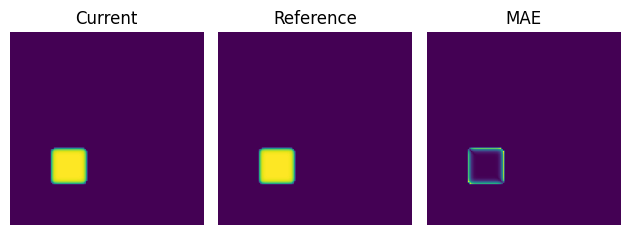

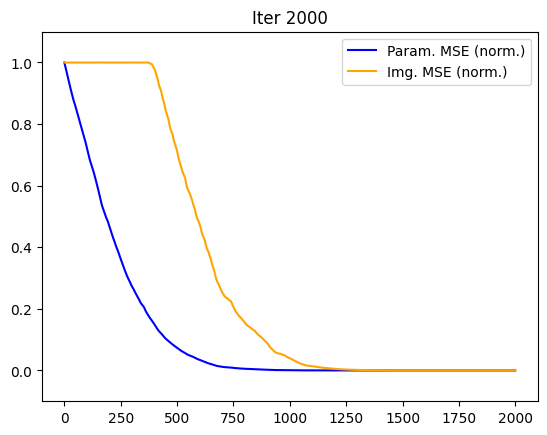

Iter 2001 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 2002 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 2003 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 2004 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 2005 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 2006 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 2007 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 2008 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 2009 - Img.Loss: 0.0000 - Param.Loss: 0.0000
Iter 2010 - Img.Loss: 0.0000 - Param.Loss: 0.0001
Iter 2011 - Img.Loss: 0.0000 - Param.Loss: 0.0001
Iter 2012 - Img.Loss: 0.0000 - Param.Loss: 0.0001
Iter 2013 - Img.Loss: 0.0000 - Param.Loss: 0.0001
Iter 2014 - Img.Loss: 0.0000 - Param.Loss: 0.0001
Iter 2015 - Img.Loss: 0.0000 - Param.Loss: 0.0001
Iter 2016 - Img.Loss: 0.0000 - Param.Loss: 0.0001
Iter 2017 - Img.Loss: 0.0000 - Param.Loss: 0.0001
Iter 2018 - Img.Loss: 0.0000 - Param.Loss: 0.0001
Iter 2019 - Img.Loss: 0.0000 - Param.Loss: 0.0001
Iter 2020 - Img.Loss: 0.0000 - Param.Loss: 0.0001


In [128]:
for i, theta in enumerate(starting_points):
    print(i)
    logging_box(theta.clone(), [], [], 0, 1)
    # --------------- run optimization Adam
    
    for j, lr in enumerate(lr_list):
        adam_box_params['learning_rate'] = lr
        time4 = time.time()
        x_adam, _, _ = adam_opt(render_smooth, theta.clone(), adam_box_params['epochs'], log_func=logging_box, f_args=f_args, kernel_args=kernel_args,
                        sampler_args=sampler_args, opt_args=adam_box_params, ctx_args=ctx_args, device=device)
        time5 = time.time()
        box_time_hist[i, 3+j] = time5 - time4
        param_loss = torch.nn.MSELoss()(x_adam, gt_theta).item()
        box_loss_hist[i, 3+j] = param_loss#render_smooth(x_adam.unsqueeze(0), f_args['gt_img'])
    
    

In [229]:
np.save('box_loss_hist.npy', box_loss_hist)
np.save('box_time_hist.npy', box_time_hist)
box_loss_hist = np.load('box_loss_hist.npy')
box_time_hist = np.load('box_time_hist.npy')

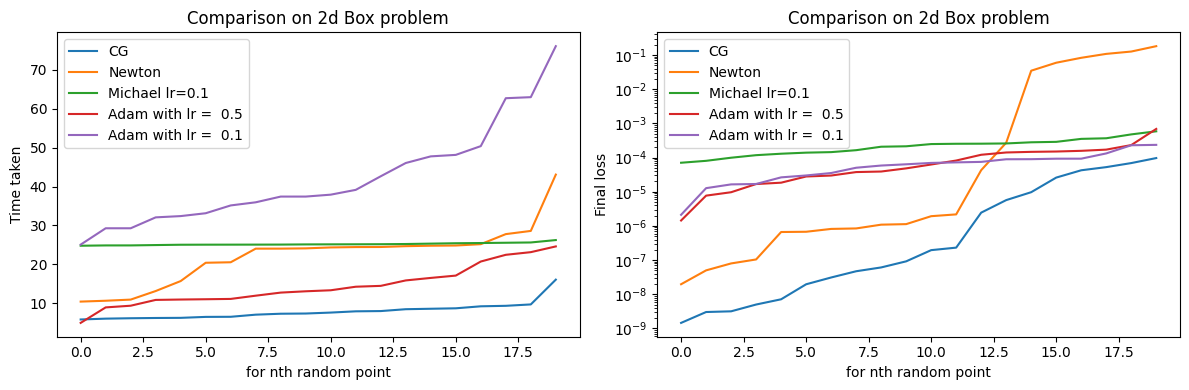

In [230]:
# Draw time plot and loss plot
box_loss_hist = np.sort(box_loss_hist, axis=0)
box_time_hist = np.sort(box_time_hist, axis=0)
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(box_time_hist[:, 0], label='CG')
plt.plot(box_time_hist[:, 1], label='Newton')
# plt.plot(box_time_hist[:, 2], label='BFGS')
plt.plot(box_time_hist[:, -1], label='Michael lr={}'.format(mi_hparams['learning_rate']))
for i, lr in enumerate(lr_list):
    plt.plot(box_time_hist[:, 3+i], label='Adam with lr =  {}'.format(lr))
plt.xlabel('for nth random point')
plt.ylabel('Time taken')
plt.title('Comparison on 2d Box problem')
plt.legend()
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(box_loss_hist[:, 0], label='CG')
plt.plot(box_loss_hist[:, 1], label='Newton')
# plt.plot(box_loss_hist[:, 2], label='BFGS')
plt.plot(box_loss_hist[:, -1], label='Michael lr={}'.format(mi_hparams['learning_rate']))
for i, lr in enumerate(lr_list):
    plt.plot(box_loss_hist[:, 3+i], label='Adam with lr =  {}'.format(lr))
plt.xlabel('for nth random point')
plt.ylabel('Final loss')
plt.yscale('log')
plt.title('Comparison on 2d Box problem')
plt.legend()
plt.tight_layout()
# print(box_loss_hist)
# print(box_time_hist)

# Example on box 3D param

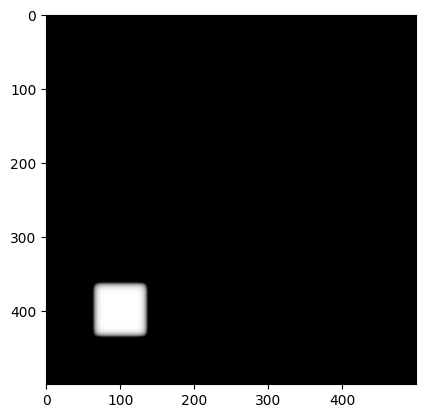

In [19]:
# From Michael's code box example
def get_rendering(theta,  update_fn=None, ctx_args=None): 
  return draw_rect_3param(theta[0], theta[1], theta[2])

scale = 500
def draw_rect_3param(px, py, size):   
  s, exp = scale, 10
  w, h = min(abs(size), s/2), min(abs(size), s/2)
  px = max(0+h, min(s-h, px))
  py = max(0+w, min(s-w, py))
  ss = torch.arange(s, device=device)
  x, y = torch.meshgrid(ss, ss)
  image = 1 - 2*(abs(((py - x)/w))**exp + abs((y - px)/h)**exp)
  return torch.flipud(image.clamp(0, 1)).unsqueeze(-1)

plt.imshow(draw_rect_3param(100, 100, 40).cpu().numpy().squeeze(), cmap='gray')

def render_smooth(perturbed_theta, gt_img):
  '''
  Michael's code but without the average image
  '''
  with torch.no_grad():
      imgs, losses = [], []
      for j in range(perturbed_theta.shape[0]):       # for each sample
          perturbed_img = get_rendering(perturbed_theta[j, :])
          perturbed_loss = torch.nn.MSELoss()(perturbed_img, gt_img)
          imgs.append(perturbed_img)
          losses.append(perturbed_loss)
      loss = torch.stack(losses)
  return loss

def logging_box(theta, img_errors, param_errors, i, interval=5, **f_args):
    # plotting, logging, printing...
    theta = theta.squeeze()
    img_curr = get_rendering(theta)
    img_loss = torch.nn.MSELoss()(img_curr, ref_img).item()
    param_loss = torch.nn.MSELoss()(theta, gt_theta).item()
    img_errors.append(img_loss)
    param_errors.append(param_loss)

    print(f"Iter {i+1} - Img.Loss: {img_loss:.4f} - Param.Loss: {param_loss:.4f}")
    if (i+1) % interval == 0: 
        clear_output(wait=True)
        show_with_error(img_curr, ref_img, iter=i+1)
        plt_errors(img_errors, param_errors, title=f'Iter {i+1}')
    return img_errors, param_errors

n_samples = 10
sigma = 0.1

torch.manual_seed(0)

# set up initial and gt translation:
theta = torch.tensor([0.5, 0.6, 0.2], device=device)*scale
gt_theta = torch.tensor([0.3, 0.33, 0.15], device=device)*scale

init_img = get_rendering(theta)
ref_img = get_rendering(gt_theta)


## Individual test

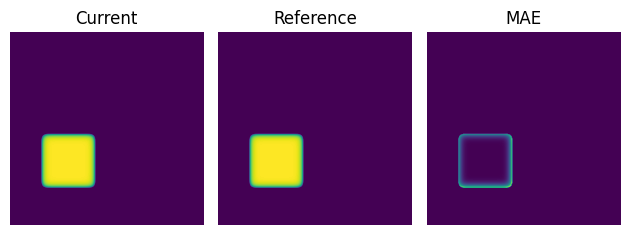

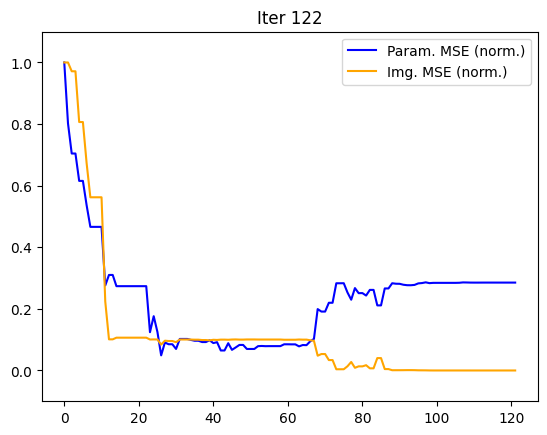

[[250.         300.         300.        ]
 [248.63194    294.9861     266.4006    ]
 [250.17061    291.51602    246.76413   ]
 [250.17061    291.51602    246.76413   ]
 [249.50978    289.78027    226.85056   ]
 [249.50978    289.78027    226.85056   ]
 [248.81401    287.9555     206.94614   ]
 [247.40955    286.3179     187.06284   ]
 [247.40955    286.3179     187.06284   ]
 [247.40955    286.3179     187.06284   ]
 [247.40955    286.3179     187.06284   ]
 [242.31715    279.4165      87.431335  ]
 [238.29323    272.84293      4.0780864 ]
 [238.29323    272.84293      4.0780864 ]
 [233.75143    242.11075    -17.86067   ]
 [233.75143    242.11075    -17.86067   ]
 [233.75143    242.11075    -17.86067   ]
 [233.75143    242.11075    -17.86067   ]
 [233.75143    242.11075    -17.86067   ]
 [233.75143    242.11075    -17.86067   ]
 [233.75143    242.11075    -17.86067   ]
 [233.75143    242.11075    -17.86067   ]
 [233.75143    242.11075    -17.86067   ]
 [214.07368    207.18497     12.40

In [13]:
# plt.rcParams['figure.figsize'] = (12, 6)
n_samples = 6
sigma = scale/6

ctx_args = {'nsamples':n_samples}
cg_box_hparams = {'sigma_annealing': True,
           'sigma': sigma,
           'epochs': 400,
           'anneal_const_first': 20,
           'anneal_const_last': 300,
           'anneal_sigma_min': 0.05,
           'tol': 5e-5, # tolerance for CG
           'HVP':False, # using HVP or full hessian
           'TR':True,
           'TR_bound': 20, # number or 'dynamic'
           'NR_max_iter': 300, # max iter for NR line search in CG
           'NR_tol': 1e-3, # tolerance for NR line search in CG
           'recompute': 1, # recompute the exact residual every n iterations
           'conv_thres': 5, # convergence threshold
           'plot_interval':20 # number of iterations to plot
           }
# --------------- run optimization CG
max_iter = cg_box_hparams['epochs']
theta = torch.tensor([0.5, 0.6, 0.6], device=device)*scale
show_with_error(init_img, ref_img, iter=0)
f_args = {'gt_img': ref_img}
kernel_args = {'sigma': sigma}
sampler = 'importance_hessgauss'
sampler_args = {'sigma': sigma, 'is_antithetic': True, 'dir':(0,0)}
x, _, x_list = NCG_smooth(render_smooth, theta, max_iter, log_func=logging_box, f_args=f_args, kernel_args=kernel_args, 
           sampler_args=sampler_args, opt_args=cg_box_hparams, ctx_args=ctx_args, device=device)
print(x_list)

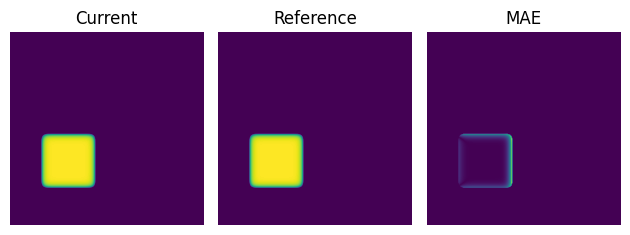

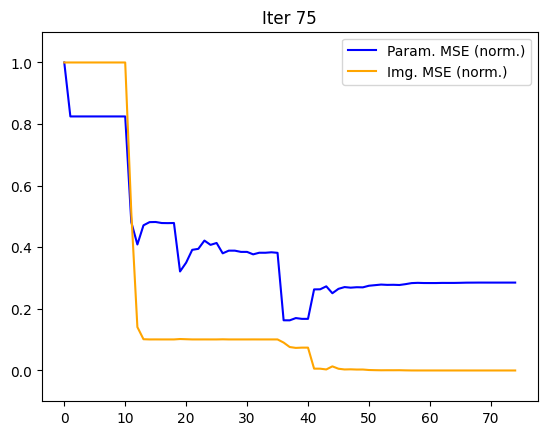

[[ 2.5000000e+02  3.0000000e+02  3.0000000e+02]
 [ 2.5224710e+02  2.9633182e+02  2.6821722e+02]
 [ 2.5224710e+02  2.9633182e+02  2.6821722e+02]
 [ 2.5224710e+02  2.9633182e+02  2.6821722e+02]
 [ 2.5224710e+02  2.9633182e+02  2.6821722e+02]
 [ 2.5224710e+02  2.9633182e+02  2.6821722e+02]
 [ 2.5224710e+02  2.9633182e+02  2.6821722e+02]
 [ 2.5224710e+02  2.9633182e+02  2.6821722e+02]
 [ 2.5224710e+02  2.9633182e+02  2.6821722e+02]
 [ 2.5224710e+02  2.9633182e+02  2.6821722e+02]
 [ 2.5224710e+02  2.9633182e+02  2.6821722e+02]
 [ 2.4688136e+02  3.0571738e+02  1.6880334e+02]
 [ 2.4222084e+02  3.1661688e+02  4.7320068e+01]
 [ 2.4145287e+02  3.2015494e+02  6.2355347e+00]
 [ 2.4131442e+02  3.2018628e+02  4.6372104e-01]
 [ 2.3959026e+02  3.2009918e+02 -2.0064003e+00]
 [ 2.3970404e+02  3.2020816e+02  1.0144089e-01]
 [ 2.3971028e+02  3.2014691e+02  1.4477420e-01]
 [ 2.3973656e+02  3.2015823e+02 -1.8598974e-02]
 [ 2.0106984e+02  3.0040878e+02  8.6449223e+00]
 [ 2.0297534e+02  3.0002325e+02 -6.03659

In [20]:
sigma = scale/10
cg_box_hparams = {'sigma_annealing': True,
           'sigma': sigma,
           'anneal_const_first': 0,
           'anneal_const_last': 230,
           'anneal_sigma_min': 0.05,
           'epochs': 300,
           'conv_thres': 5, # convergence threshold
           'tol': 5e-5, # tolerance for CG
           'TR':True,
           'TR_bound': 'dynamic', # number or 'dynamic'
           'HVP':True, # using HVP or full hessian
           'NR_max_iter': 2, # max iter for NR line search in CG
           'NR_tol': 1e-3, # tolerance for NR line search in CG
           'recompute': 5, # recompute the exact residual every n iterations
           'plot_interval':20 # number of iterations to plot
           }
# --------------- run optimization CG
max_iter = cg_box_hparams['epochs']
theta = torch.tensor([0.5, 0.6, 0.6], device=device)*scale
show_with_error(init_img, ref_img, iter=0)
f_args = {'gt_img': ref_img}
kernel_args = {'sigma': sigma}
sampler = 'importance_hessgauss'
sampler_args = {'sigma': sigma, 'is_antithetic': True, 'dir':(0,0)}
x, _, x_list = NCG_smooth(render_smooth, theta, max_iter, log_func=logging_box, f_args=f_args, kernel_args=kernel_args, 
           sampler_args=sampler_args, opt_args=cg_box_hparams, ctx_args=ctx_args, device=device)
print(x_list)

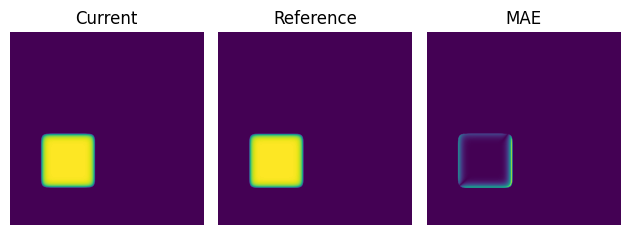

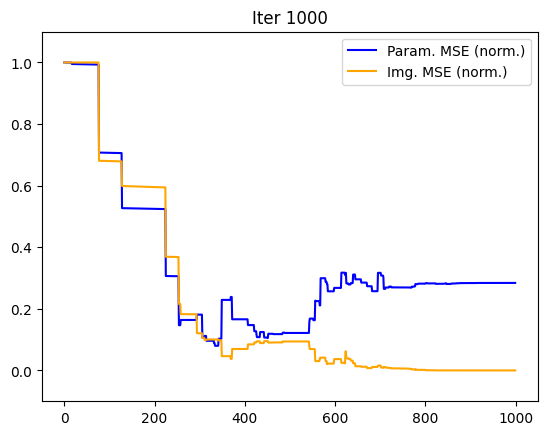

(tensor([[149.1795, 165.4975, -74.7092]], device='cuda:0'),
 array([[250.     , 300.     , 300.     ],
        [250.00092, 299.99918, 299.99396],
        [249.99976, 299.99847, 299.988  ],
        ...,
        [149.17952, 165.49748, -74.70917],
        [149.17952, 165.49748, -74.70917],
        [149.17952, 165.49748, -74.70917]], dtype=float32))

In [18]:
# newton
ctx_args = {'nsamples':n_samples}

newton_box_hparams = {'sigma_annealing': True,
           'sigma': sigma,
           'epochs': 1000,
           'anneal_const_first': 0,
           'anneal_const_last': 100,
           'anneal_sigma_min': 0.05,
           'TR':True,
           'TR_bound': 150,
           'TR_rate': 0.1,
           'learning_rate':0.5,
           'conv_thres': 7, # convergence threshold
           'tol': 5e-6, # tolerance for newton
           'hessian mod':True,
           'plot_interval':100 # number of iterations to plot
           }

# --------------- run optimization
max_iter = newton_box_hparams['epochs']
theta = torch.tensor([0.5, 0.6, 0.6], device=device)*scale
show_with_error(init_img, ref_img, iter=0)
f_args = {'gt_img': ref_img}
kernel_args = {'sigma': sigma}
sampler = 'importance_hessgauss'
sampler_args = {'sigma': sigma, 'is_antithetic': True, 'dir':(0,0)}
newton_smooth(render_smooth, theta, max_iter, log_func=logging_box, f_args=f_args, kernel_args=kernel_args, 
           sampler_args=sampler_args, opt_args=newton_box_hparams, ctx_args=ctx_args, device=device)


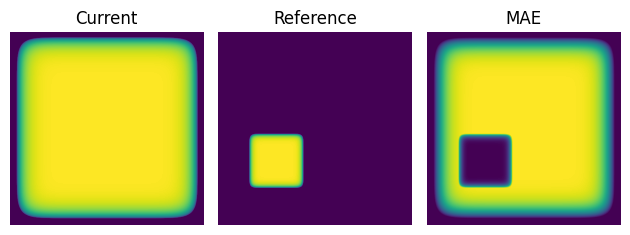

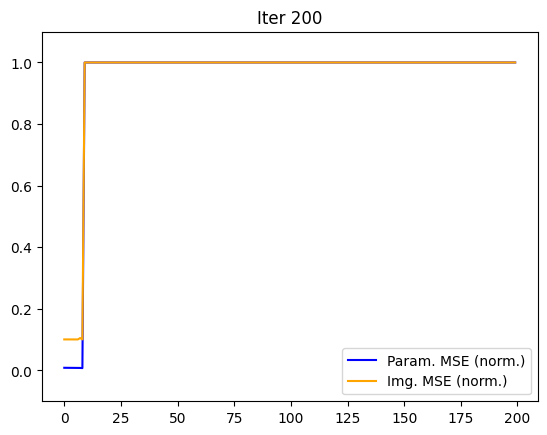

(tensor([[ -823.9872, -1708.6093, -1334.0074]], device='cuda:0',
        requires_grad=True),
 [0.058544762432575226,
  0.058512985706329346,
  0.058512523770332336,
  0.058512311428785324,
  0.0585089847445488,
  0.05850963294506073,
  0.0585089847445488,
  0.06111888214945793,
  0.05856526643037796,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.5805256962776184,
  0.58052569627

In [55]:
# nBFGS
ctx_args = {'nsamples':n_samples}
sigma=scale/10
BFGS_box_hparams = {'sigma_annealing': True,
           'sigma': sigma,
           'epochs': 200,
           'anneal_const_first': 0,
           'anneal_const_last': 100,
           'anneal_sigma_min': 0.05,
           'TR':False,
           'TR_bound': 1e-3,
           'learning_rate':0.5,
           'line_search_fn': None, #'strong_wolfe',
           'history_size': 5,
           'tol': 5e-6, # tolerance for newton
           'plot_interval':100 # number of iterations to plot
           }

# --------------- run optimization
max_iter = BFGS_box_hparams['epochs']
theta = torch.tensor([0.5, 0.6, 0.6], device=device)*scale
show_with_error(init_img, ref_img, iter=0)
f_args = {'gt_img': ref_img}
kernel_args = {'sigma': sigma}
sampler_args = {'sigma': sigma, 'is_antithetic': True}
BFGS_opt(render_smooth, theta, max_iter, log_func=logging_box, f_args=f_args, kernel_args=kernel_args, 
           sampler_args=sampler_args, opt_args=BFGS_box_hparams, ctx_args=ctx_args, device=device)

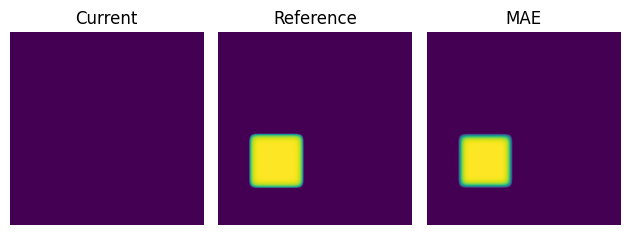

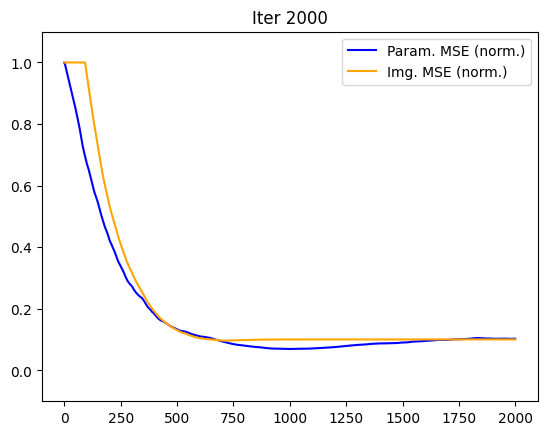

In [34]:
# adam
ctx_args = {'nsamples':n_samples}

adam_box_params = {'sigma_annealing': True,
           'sigma': sigma,
           'anneal_const_first': 400,
           'anneal_const_last': 1000,
           'anneal_sigma_min': 0.05,
           'epochs': 2000,
           'learning_rate':0.5,
           'plot_interval':100, # number of iterations to plot
           'conv_thres': 10, # convergence threshold
           'tol':1e-7
           }
# --------------- run optimization Adam
max_iter = adam_box_params['epochs']
theta = torch.tensor([0.5, 0.6, 0.6], device=device)*scale
show_with_error(init_img, ref_img, iter=0)
f_args = {'gt_img': ref_img}
kernel_args = {'sigma': sigma}
sampler = 'importance_hessgauss'
sampler_args = {'sigma': sigma, 'is_antithetic': True, 'dir':(0,0)}
x_adam, _, _ = adam_opt(render_smooth, theta, adam_box_params['epochs'], log_func=logging_box, f_args=f_args, kernel_args=kernel_args,
                sampler_args=sampler_args, opt_args=adam_box_params, ctx_args=ctx_args, device=device)

In [27]:
mi_hparams = {'nsamples': n_samples,
            'sigma': sigma,
            'learning_rate': 0.1,
            'sigma_annealing': True,
            'epochs': 5000,
            'anneal_const_first': 500,
            'anneal_const_last': 1000,
            'anneal_sigma_min': 0.01,
            'conv_thres': 10, # convergence threshold
            'tol':1e-7,
            'plot_interval':200
           }

# set up mi_ctx_args: 
mi_ctx_args = {'antithetic': True, 'nsamples': mi_hparams['nsamples'], 'sigma': mi_hparams['sigma'],
            'sampler': 'importance', 'device': device, 'gt_image': ref_img, 'update_fn': None}

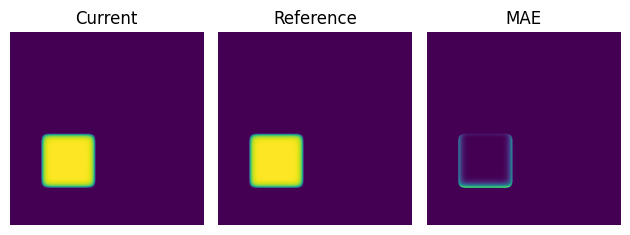

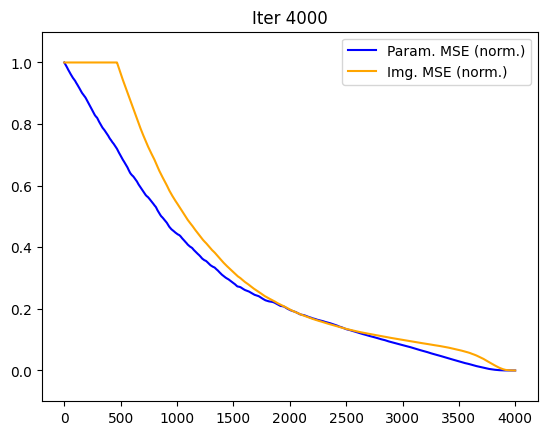

Iter 4001 - Img.Loss: 0.0000 - Param.Loss: 0.0491
Iter 4002 - Img.Loss: 0.0000 - Param.Loss: 0.0453
Iter 4003 - Img.Loss: 0.0000 - Param.Loss: 0.0420
Iter 4004 - Img.Loss: 0.0000 - Param.Loss: 0.0390
Iter 4005 - Img.Loss: 0.0000 - Param.Loss: 0.0360
Iter 4006 - Img.Loss: 0.0000 - Param.Loss: 0.0332
Iter 4007 - Img.Loss: 0.0000 - Param.Loss: 0.0307
Iter 4008 - Img.Loss: 0.0000 - Param.Loss: 0.0282
Iter 4009 - Img.Loss: 0.0000 - Param.Loss: 0.0260
Iter 4010 - Img.Loss: 0.0000 - Param.Loss: 0.0240
Iter 4011 - Img.Loss: 0.0000 - Param.Loss: 0.0222
Iter 4012 - Img.Loss: 0.0000 - Param.Loss: 0.0205
Iter 4013 - Img.Loss: 0.0000 - Param.Loss: 0.0189
Iter 4014 - Img.Loss: 0.0000 - Param.Loss: 0.0176
Iter 4015 - Img.Loss: 0.0000 - Param.Loss: 0.0163
Iter 4016 - Img.Loss: 0.0000 - Param.Loss: 0.0150
Iter 4017 - Img.Loss: 0.0000 - Param.Loss: 0.0138
Iter 4018 - Img.Loss: 0.0000 - Param.Loss: 0.0128
Iter 4019 - Img.Loss: 0.0000 - Param.Loss: 0.0117
Iter 4020 - Img.Loss: 0.0000 - Param.Loss: 0.0108


In [28]:
show_with_error(init_img, ref_img, iter=0)
    
theta = torch.tensor([0.5, 0.6, 0.6], device=device)*scale
logging_box(theta.clone(), [], [], 0, 1)
# --------------- run optimization MI
x_mi, _, _ = mi_opt(theta.clone(), mi_hparams['epochs'], log_func=logging_box, opt_args=mi_hparams, ctx_args=mi_ctx_args, device=device)

## Batch test

In [65]:
# comparison
def log_none(*args, **kargs):
    return [],[]

gt_theta = torch.tensor([0.3, 0.3, 0.15], device=device)*scale
ref_img = get_rendering(gt_theta)

n_samples = 6
sigma = scale/15
ctx_args = {'nsamples':n_samples}

cg_box_hparams = {'sigma_annealing': True,
           'sigma': sigma,
           'epochs': 400,
           'anneal_const_first': 20,
           'anneal_const_last': 300,
           'anneal_sigma_min': 0.05,
           'tol': 5e-5, # tolerance for CG
           'TR':True,
           'HVP':False, # using HVP or full hessian
           'TR_bound': 20,
           'TR_rate': 0.5,
           'NR_max_iter': 300, # max iter for NR line search in CG
           'NR_tol': 1e-3, # tolerance for NR line search in CG
           'recompute': 1, # recompute the exact residual every n iterations
           'conv_thres': 5, # convergence threshold
           'plot_interval':20 # number of iterations to plot
           }

cg_box_hparams = {'sigma_annealing': True,
           'sigma': sigma,
           'epochs': 300,
           'anneal_const_first': 0,
           'anneal_const_last': 230,
           'anneal_sigma_min': 0.05,
           'tol': 5e-5, # tolerance for CG
           'HVP':True, # using HVP or full hessian
           'TR':True,
           'TR_bound': 'dynamic', # number or 'dynamic'
           'NR_max_iter': 2, # max iter for NR line search in CG
           'NR_tol': 1e-3, # tolerance for NR line search in CG
           'recompute': 5, # recompute the exact residual every n iterations
           'conv_thres': 5, # convergence threshold
           'plot_interval':20 # number of iterations to plot
           }

newton_box_hparams = {'sigma_annealing': True,
           'sigma': sigma,
           'epochs': 1200,
           'anneal_const_first': 200,
           'anneal_const_last': 0,
           'anneal_sigma_min': 0.05,
           'TR':True,
           'TR_bound': 200,
           'TR_rate': 1e-2,
           'learning_rate':0.5,
           'conv_thres': 7, # convergence threshold
           'tol': 5e-6, # tolerance for newton
           'hessian mod':True,
           'plot_interval':100 # number of iterations to plot
           }


adam_box_params = {'sigma_annealing': True,
           'sigma': sigma,
           'anneal_const_first': 200,
           'anneal_const_last': 0,
           'anneal_sigma_min': 0.01,
           'conv_thres': 10, # convergence threshold
           'epochs': 2000,
           'learning_rate':1e-1,
           'plot_interval':200, # number of iterations to plot
           'tol':1e-6
           }


BFGS_box_hparams = {'sigma_annealing': True,
           'sigma': sigma,
           'epochs': 200,
           'anneal_const_first': 0,
           'anneal_const_last': 100,
           'anneal_sigma_min': 0.05,
           'TR':False,
           'TR_bound': 1e-3,
           'learning_rate':0.5,
           'line_search_fn': None, #'strong_wolfe',
           'history_size': 5,
           'tol': 5e-6, # tolerance for newton
           'plot_interval':100 # number of iterations to plot
           }

mi_hparams = {'nsamples': n_samples,
            'sigma': sigma,
            'learning_rate': 0.1,
            'sigma_annealing': True,
            'epochs': 6000,
            'anneal_const_first': 0,
            'anneal_const_last': 0,
            'anneal_sigma_min': 0.05,
            'conv_thres': 10, # convergence threshold
            'tol':1e-6,
            'plot_interval':1000
           }

# set up mi_ctx_args: 
mi_ctx_args = {'antithetic': True, 'nsamples': mi_hparams['nsamples'], 'sigma': mi_hparams['sigma'],
            'sampler': 'importance', 'device': device, 'gt_image': ref_img, 'update_fn': None}
f_args = {'gt_img': ref_img}
kernel_args = {'sigma': sigma}
sampler_args = {'sigma': sigma, 'is_antithetic': True, 'dir':(0,0)}

# lr_list = [0.5, 0.1, 0.05, 0.01, 1e-3]
lr_list = [0.5, 0.1]


In [63]:
n_starting_points = 20
starting_points = (torch.rand(n_starting_points, 3, device=device)*0.3 + 0.2)*scale
box_time_hist = np.zeros((n_starting_points, 3+2*len(lr_list))) # 1 for CG, 1 for Newton, 1 for BFGS, lr for michale, lr for adam
box_loss_hist = np.zeros((n_starting_points, 3+2*len(lr_list)))

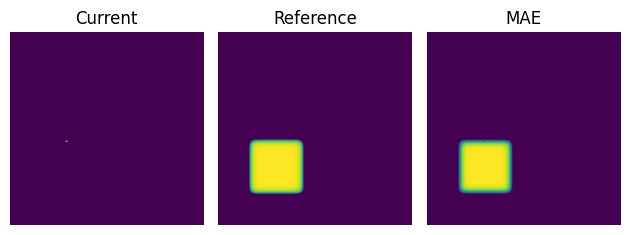

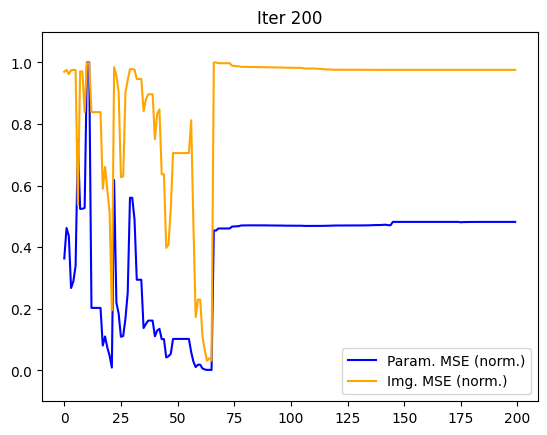

Iter 201 - Img.Loss: 0.0585 - Param.Loss: 3218.4695
Iter 202 - Img.Loss: 0.0585 - Param.Loss: 3218.8828
Iter 203 - Img.Loss: 0.0585 - Param.Loss: 3218.9949
Iter 204 - Img.Loss: 0.0585 - Param.Loss: 3218.9395
Iter 205 - Img.Loss: 0.0585 - Param.Loss: 3218.9998
Iter 206 - Img.Loss: 0.0585 - Param.Loss: 3218.8481


KeyboardInterrupt: 

In [58]:
for i, theta in enumerate(starting_points):
    print(i)
    logging_box(theta.clone(), [], [], 0, 1)
    # --------------- run optimization CG
    time1 = time.time()
    x_cg, _ ,_ = NCG_smooth(render_smooth, theta.clone(), cg_box_hparams['epochs'], log_func=logging_box, f_args=f_args, kernel_args=kernel_args, 
            sampler_args=sampler_args, opt_args=cg_box_hparams, ctx_args=ctx_args, device=device)
    time2 = time.time()
    box_time_hist[i, 0] = time2 - time1
    param_loss = torch.nn.MSELoss()(x_cg, gt_theta).item()
    box_loss_hist[i, 0] = render_smooth(x_cg, f_args['gt_img'])
    


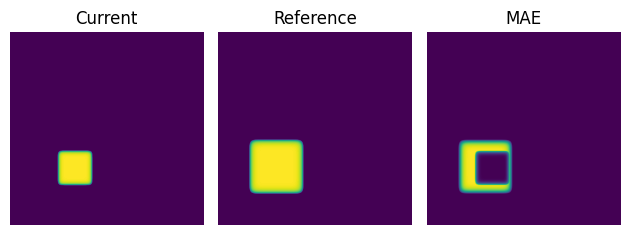

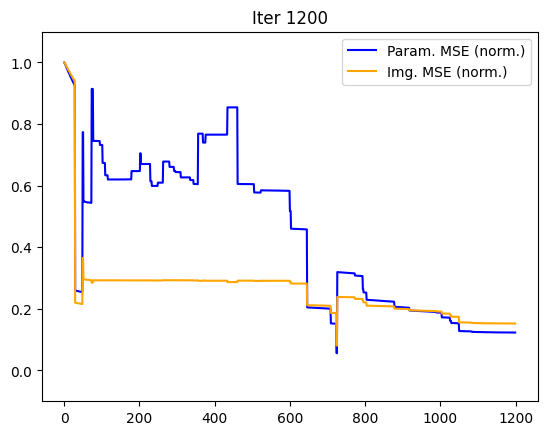

In [118]:
for i, theta in enumerate(starting_points):
    print(i)
    logging_box(theta.clone(), [], [], 0, 1)
    time2 = time.time()
    # --------------- run optimization newton
    
    x_newton, _ = newton_smooth(render_smooth, theta.clone(), newton_box_hparams['epochs'], log_func=logging_box, f_args=f_args, kernel_args=kernel_args, 
            sampler_args=sampler_args, opt_args=newton_box_hparams, ctx_args=ctx_args, device=device)
    time3 = time.time()
    box_time_hist[i, 1] = time3 - time2
    param_loss = torch.nn.MSELoss()(x_newton, gt_theta).item()
    box_loss_hist[i, 1] = render_smooth(x_newton, f_args['gt_img'])
    


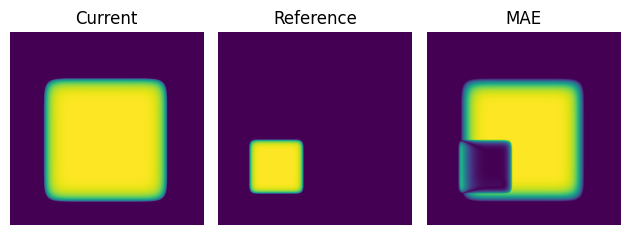

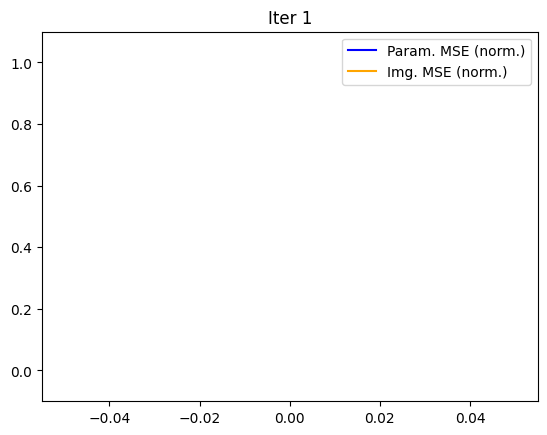

torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
Iter 1 - Img.Loss: 0.2381 - Param.Loss: 7363.5562
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size([12, 3])
torch.Size([12, 3]) torch.Size

KeyboardInterrupt: 

In [67]:
for i, theta in enumerate(starting_points):
    print(i)
    logging_box(theta.clone(), [], [], 0, 1)
    time3 = time.time()
    x_BFGS, _, _ = BFGS_opt(render_smooth, theta.clone(), BFGS_box_params['epochs'], log_func=logging_box, f_args=f_args, kernel_args=kernel_args,
                    sampler_args=sampler_args, opt_args=BFGS_box_params, ctx_args=ctx_args, device=device)
    time4 = time.time()
    box_loss_hist[i, 2] = torch.nn.MSELoss()(x_BFGS, gt_theta).item()
    box_time_hist[i, 2] = time4 - time3

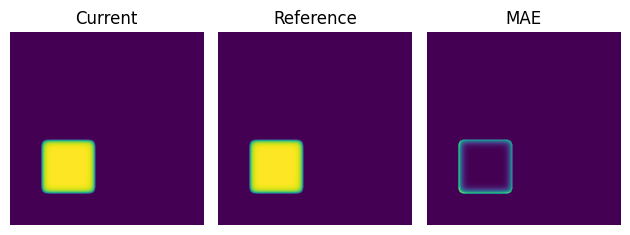

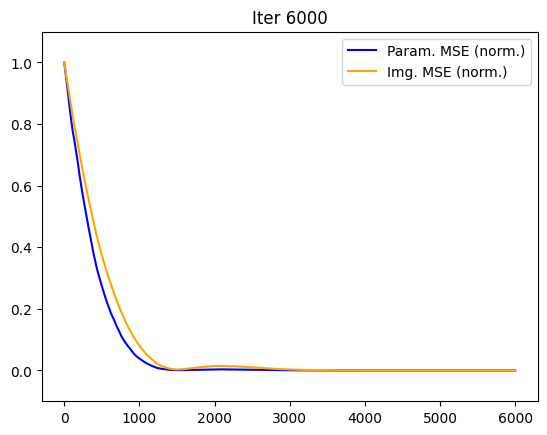

In [ ]:
show_with_error(init_img, ref_img, iter=0)
for i, theta in enumerate(starting_points):
    print(i)
    logging_box(theta.clone(), [], [], 0, 1)
    for j, lr in enumerate(lr_list):
        mi_hparams['learning_rate'] = lr
        # --------------- run optimization MI
        time1 = time.time()
        x_mi, _, _ = mi_opt(theta.clone(), mi_hparams['epochs'], log_func=logging_box, opt_args=mi_hparams, ctx_args=mi_ctx_args, device=device)
        time2 = time.time()
        box_time_hist[i, 3+len(lr_list)+j] = time2 - time1
        param_loss = torch.nn.MSELoss()(x_mi, gt_theta).item()
        box_loss_hist[i, 3+len(lr_list)+j] = render_smooth(x_mi.unsqueeze(0), f_args['gt_img'])
    

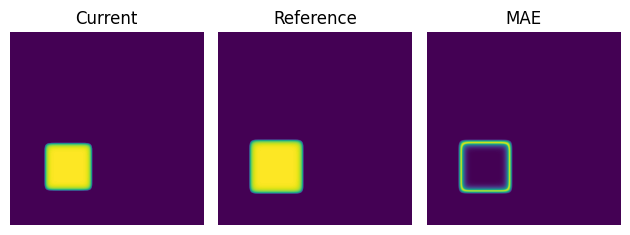

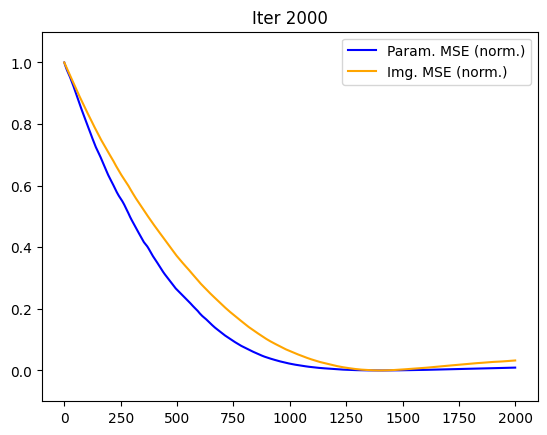

In [ ]:
for i, theta in enumerate(starting_points):
    print(i)
    logging_box(theta.clone(), [], [], 0, 1)
    # --------------- run optimization Adam
    
    for j, lr in enumerate(lr_list):
        adam_box_params['learning_rate'] = lr
        time4 = time.time()
        x_adam, _, _ = adam_opt(render_smooth, theta.clone(), adam_box_params['epochs'], log_func=logging_box, f_args=f_args, kernel_args=kernel_args,
                        sampler_args=sampler_args, opt_args=adam_box_params, ctx_args=ctx_args, device=device)
        time5 = time.time()
        box_time_hist[i, 3+j] = time5 - time4
        param_loss = torch.nn.MSELoss()(x_adam, gt_theta).item()
        box_loss_hist[i, 3+j] = render_smooth(x_adam.unsqueeze(0), f_args['gt_img'])
    
    

In [ ]:
np.save('box_loss_hist.npy', box_loss_hist)
np.save('box_time_hist.npy', box_time_hist)
box_loss_hist = np.load('box_loss_hist.npy')
box_time_hist = np.load('box_time_hist.npy')

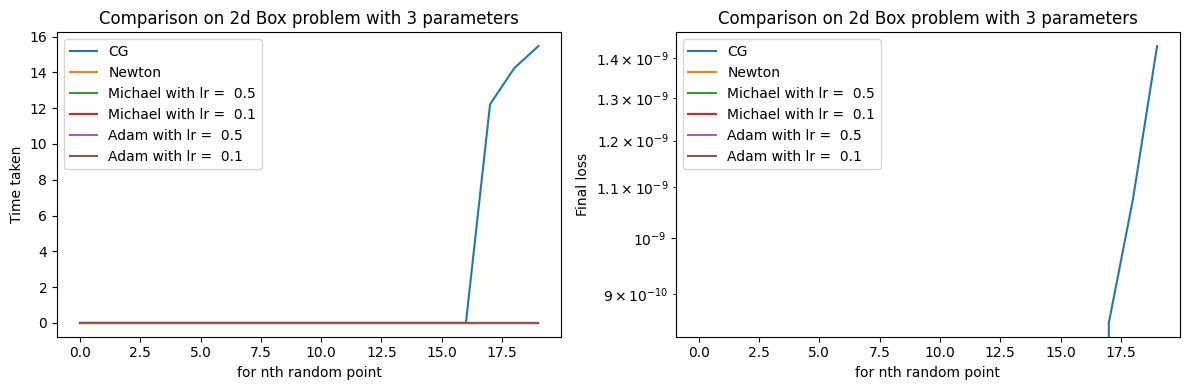

In [61]:
# Draw time plot and loss plot
box_loss_hist = np.sort(box_loss_hist, axis=0)
box_time_hist = np.sort(box_time_hist, axis=0)
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(box_time_hist[:, 0], label='CG')
plt.plot(box_time_hist[:, 1], label='Newton')
# plt.plot(box_time_hist[:, 2], label='BFGS')
for i, lr in enumerate(lr_list):
    plt.plot(box_time_hist[:, 3+i], label='Michael with lr =  {}'.format(lr))
for i, lr in enumerate(lr_list):
    plt.plot(box_time_hist[:, 3+len(lr_list)+i], label='Adam with lr =  {}'.format(lr))
plt.xlabel('for nth random point')
plt.ylabel('Time taken')
plt.title('Comparison on 2d Box problem with 3 parameters')
plt.legend()
plt.tight_layout()

plt.subplot(1,2,2)
plt.plot(box_loss_hist[:, 0], label='CG')
plt.plot(box_loss_hist[:, 1], label='Newton')
# plt.plot(box_loss_hist[:, 2], label='BFGS')
for i, lr in enumerate(lr_list):
    plt.plot(box_loss_hist[:, 3+i], label='Michael with lr =  {}'.format(lr))
for i, lr in enumerate(lr_list):
    plt.plot(box_loss_hist[:, 3+len(lr_list)+i], label='Adam with lr =  {}'.format(lr))
plt.xlabel('for nth random point')
plt.ylabel('Final loss')
plt.yscale('log')
plt.title('Comparison on 2d Box problem with 3 parameters')
plt.legend()
plt.tight_layout()
# print(box_loss_hist)
# print(box_time_hist)